In [305]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack, Column, join

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.stellar_mass_function import get_smf_bootstrap
from asap.asap_data_io import *
from asap.asap_model_setup import *
from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *
from asap.full_mass_profile_model import *
from asap.asap_mass_model import * 
from asap.asap_model_prediction import asap_predict_mhalo 
from asap.stellar_mass_function import *

from hsc_massive.smhm import * 
from hsc_massive import s16a_path, mass_function, weak_lensing, \
    sample_selection, catalog_summary, plotting

from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

from asap.ellipse_selection_functions import ellipse_split_2d

from dsigma.stack_ds import stack_delta_sigma
from dsigma.plots import show_delta_sigma_profiles

#envir = s16a_path.set_env(version='astro5')
envir = s16a_path.set_env(version='kungpao')

from palettable.cartocolors.qualitative import Safe_10, Vivid_10
from palettable.cmocean.diverging import Balance_20
DIV = Balance_20.mpl_colormap

color_circle = Safe_10.mpl_colors
color_circle_2 = Vivid_10.mpl_colors

RSMA_COMMON = np.arange(0.4, 4.2, 0.01)
RR50_COMMON = np.arange(0.0, 9.0, 0.01)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [479]:
ORG = plotting.ORG
BLK = plotting.BLK
BLU = plotting.BLU
GRN = plotting.GRN
PUR = plotting.PUR

### Load the model and data

In [243]:
test_dir = 'test'

model_str = 'asap_mmax_m10_frac4_test_B'

config_file = os.path.join(test_dir, model_str + '.yaml')
burnin_file = os.path.join(test_dir, model_str + '_burnin.npz')
result_file = os.path.join(test_dir, model_str + '_run.npz')

cfg_ini = parse_config(config_file)
cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# UM mock catalog used in modeling
um_mock = um_data['um_mock']

um_dsig = um_data['um_mass_encl'] 

# Observations
obs_mass = obs_data['obs_mass']

obs_dsigma = obs_data['obs_wl_dsigma']

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.6.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volu

In [26]:
# Save a version of the mock catalog to match with extended UM catalog
# The matching is performed outside this notebook

um_dir = '/Volumes/data/massive/dr16a/um2/um2_new/um_smdpl_small'

um_mock_use = Table(um_mock)

um_mock_use.add_column(Column(data=np.arange(len(um_mock)) + 1, name='index'))

um_mock_use.write(os.path.join(um_dir, 'um_smdpl_0.7124_new_vagc_mpeak_11.5_use.fits'), 
                  format='fits', overwrite=True)

In [244]:
# Extended UM halo catalog
um_more = np.load(os.path.join(um_dir, 'um_smdpl_0.7124_new_vagc_mpeak_11.5_use_extended.npy'))

print(len(um_more), len(um_mock))
print(um_dsig.shape)

# Verify that they share the same order
np.all(um_more['z'] == um_mock['z'])

(791807, 791807)
(791807, 22)


True

In [838]:
# HSC massive galaxies with useful profiles

sbp_dir = os.path.join(envir['s16a'], 'sbp')
sbp_cat_dir = os.path.join(envir['s16a'], 'sbp/catalog')

mass_sbp = Table.read(os.path.join(sbp_cat_dir, 's16a_wide2_massive_sbp_cog_good.fits'),
                      format='fits')

mass_use = join(obs_mass, mass_sbp['object_id', 'sbp', 'cog'], keys='object_id', join_type='inner')

mass_good = mass_use[(mass_use['r50_max'] >= 1.0) & 
                     (mass_use['r50_max'] <= 45.0) &
                     (mass_use['logm_max'] >= 11.2) & 
                     (mass_use['logm_max'] <= 12.5) &
                     (mass_use['logm_10'] >= 10.81) &
                     (mass_use['logm_10'] <= 11.72)]

print(len(mass_sbp), len(mass_use), len(mass_good))

(35565, 35033, 25847)


### Evaluate the best fit model

In [70]:
# Best-fit parameters for frac4 model
frac4_param = [0.616, 3.508, -0.001, 0.016, 0.666, -0.176, 0.077]

# Adjust the minimum stellar mass to return the model predictions for everything
cfg_use = cfg.copy()
cfg_use['obs_min_mtot'] = 0.0

mod_model_prob = asap_predict_model_prob(frac4_param, cfg_use, 
                                         obs_data, um_data,  
                                         show_smf=False, show_dsigma=False, 
                                         return_all=True)

_, _, um_dsigma, logms_mod_inn, logms_mod_tot, sig_logm, mask_tot = mod_model_prob

# Stellar mass functions
um_smf_tot, um_smf_inn = asap_predict_smf_prob(logms_mod_tot, logms_mod_inn, sig_logm, cfg_use)

um_smf_tot_all = smf_sigma_mass_weighted(logms_mod_tot, sig_logm,
                                         cfg_use['um_volume'], 20, 10.5, 12.3)

# Galaxy-galaxy lensing signals
um_dsigma = asap_predict_dsigma(cfg_use, obs_data, 
                                um_data['um_mock'], um_data['um_mass_encl'],
                                logms_mod_tot, logms_mod_inn, mask=None)

### Assign halo mass based on KDTree

In [1000]:
central_only = (um_more['upid'] == -1)
um_more_cen = um_more[central_only]

um_mass = np.stack((logms_mod_inn[central_only], 
                    logms_mod_tot[central_only]), axis=-1)

hsc_mass = np.stack((np.array(mass_good['logm_10']),
                     np.array(mass_good['logm_max'])), axis=-1)


mstar_tree = KDTree(um_mass, leaf_size=15, metric='minkowski')

mstar_dist, mstar_idx = mstar_tree.query(hsc_mass, k=3)

mp_predict = np.asarray([np.nanmean(um_more_cen[idxs]['logmh_peak']) for idxs in mstar_idx])
mv_predict = np.asarray([np.nanmean(um_more_cen[idxs]['logmh_vir']) for idxs in mstar_idx])
rv_predict = np.asarray([np.nanmean(um_more_cen[idxs]['rvir']) for idxs in mstar_idx])
a50_predict = np.asarray([np.nanmean(um_more_cen[idxs]['a_50']) for idxs in mstar_idx])
alm_predict = np.asarray([np.nanmean(um_more_cen[idxs]['a_lmm']) for idxs in mstar_idx])

mass_mh = copy.deepcopy(mass_good)
mass_mh.add_column(Column(data=mp_predict, name='logmh_peak_tree'))
mass_mh.add_column(Column(data=mv_predict, name='logmh_vir_tree'))
mass_mh.add_column(Column(data=rv_predict, name='rvir_tree'))
mass_mh.add_column(Column(data=a50_predict, name='a50_tree'))
mass_mh.add_column(Column(data=alm_predict, name='alm_tree'))

#### Rvir-R50 plot

Text(0,0.5,'$\\log\\ (r_{50}/\\mathrm{kpc})$')

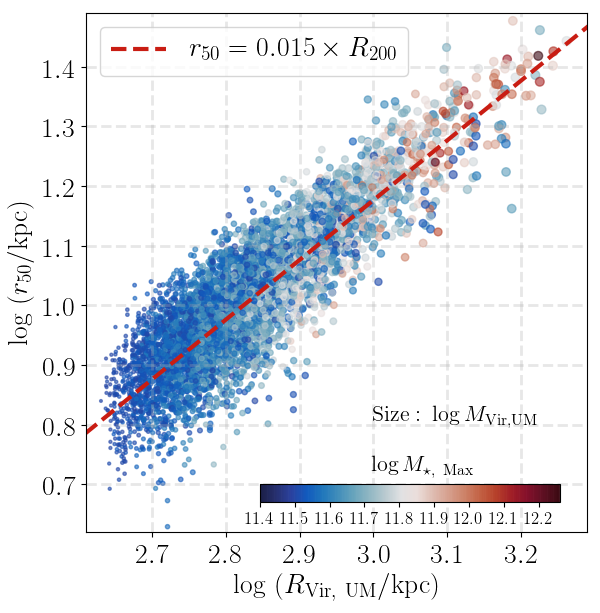

In [1001]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ms_mask = mass_mh['logm_max'] >= 11.5
    
SC = ax1.scatter(np.log10(mass_mh[ms_mask]['rvir_tree']), 
                 np.log10(mass_mh[ms_mask]['r50_100']), 
                 alpha=0.6, 
                 c=(mass_mh[ms_mask]['logm_max']),
                 s=(mass_mh[ms_mask]['logmh_vir_tree'] - 12.8) * 20,
                 label='__no_label__', cmap=DIV, vmin=11.4)

# r_n= 0.015 R200
rvir_arr = np.linspace(100, 2000, 500)
r50_arr = 0.015 * rvir_arr

ax1.plot(np.log10(rvir_arr), np.log10(r50_arr), linestyle='--', linewidth=3.0,
         c=ORG(0.8), label=r'$r_{50} = 0.015 \times R_{\rm 200}$')

ax1.text(3.00, 0.8, r'$\mathrm{Size:\ }\log M_{\mathrm{Vir,UM}}$', fontsize=16)

## Colorbar
cax = fig.add_axes([0.45, 0.18, 0.50, 0.03])
cbar = plt.colorbar(SC, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.57, 0.11, r'$\log M_{\star,\ \rm Max}$', transform=ax1.transAxes, size=16)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

ax1.legend(loc='upper left', fontsize=20)

ax1.set_xlim(2.61, 3.29)
ax1.set_ylim(0.62, 1.49)

ax1.set_xlabel(r'$\log\ (R_{\rm Vir, \ UM}/\mathrm{kpc})$', fontsize=20)
ax1.set_ylabel(r'$\log\ (r_{50}/\mathrm{kpc})$', fontsize=20)

### Assign halo mass using random forest regressor

In [991]:
from sklearn.ensemble import RandomForestRegressor

In [992]:
mstar_forest = RandomForestRegressor(n_estimators=10, criterion='mse',
                                     max_depth=None, random_state=0)

mstar_forest.fit(um_mass, um_more_cen['logmh_vir'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Text(0,0.5,'$\\log\\ (M_{\\rm Vir,\\ RandomForest/M_{\\odot}})$')

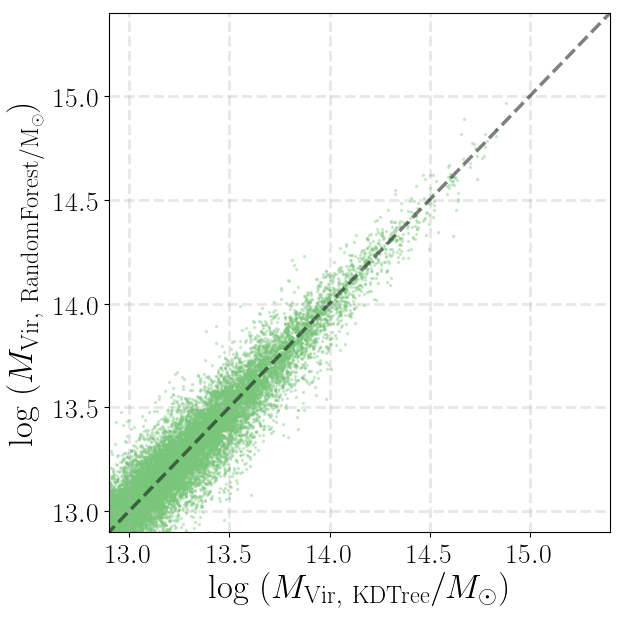

In [1002]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax1.scatter(mass_mh['logmh_vir_tree'], 
            mstar_forest.predict(hsc_mass),
            s=2, alpha=0.3, c=GRN(0.5))
    
ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.9, 15.4)
ax1.set_ylim(12.9, 15.4) 

ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ KDTree}/M_{\odot})$', fontsize=25)
ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ RandomForest/M_{\odot}})$', fontsize=25)

In [1004]:
mass_mh.add_column(Column(data=mstar_forest.predict(hsc_mass), name='logmh_vir_forest'))

### Assign halo mass using best-fit Mhalo-Mmax-M10 relation

In [957]:
from asap.lts_planefit import lts_planefit

sig_int:     0.0000      2.5984
Computing sig_int
sig_int:     0.0000      2.5984
sig_int:     0.1877     -0.3744
sig_int:     0.1641     -0.2168
sig_int:     0.1340      0.0724
sig_int:     0.1416     -0.0129
sig_int:     0.1404     -0.0008
sig_int:     0.1403      0.0000
Computing sig_int error
sig_int:     0.1403      0.0199
sig_int:     0.1877     -0.3545
sig_int:     0.1429     -0.0068
sig_int:     0.1422     -0.0001
sig_int:     0.1422      0.0007
Repeat at best fitting solution
sig_int:     0.1403      0.0000
################# Values and formal errors ################
 intercept:  13.6326 +/- 0.0024
    slopeX:  3.472 +/- 0.024
    slopeY:  -2.748 +/- 0.028
   scatter:  0.1403 +/- 0.0019
Observed rms scatter: 0.161 
z = a + b*(x - pivotx) + c*(y - pivoty)
with pivotx = 11.69 & pivoty = 11.34
##########################################################
seconds 53.91


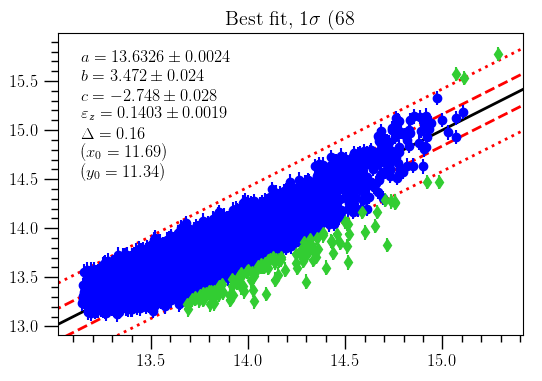

In [960]:
mask_fit = (logms_mod_tot >= 11.60) & (um_more['upid'] == -1)

x_mmax = logms_mod_tot[mask_fit]
y_minn = logms_mod_inn[mask_fit]
z_mhalo = um_more[mask_fit]['logmh_vir']
x_sig = sig_logm[mask_fit] 
y_sig = sig_logm[mask_fit] 
z_sig = sig_logm[mask_fit]

p = lts_planefit(x_mmax, y_minn, z_mhalo, 
                 x_sig, y_sig, z_sig, 
                 pivotx=np.median(x_mmax), 
                 pivoty=np.median(y_minn))

Text(0,0.5,'$\\log\\ (M_{\\rm Vir,\\ Predict/M_{\\odot}})$')

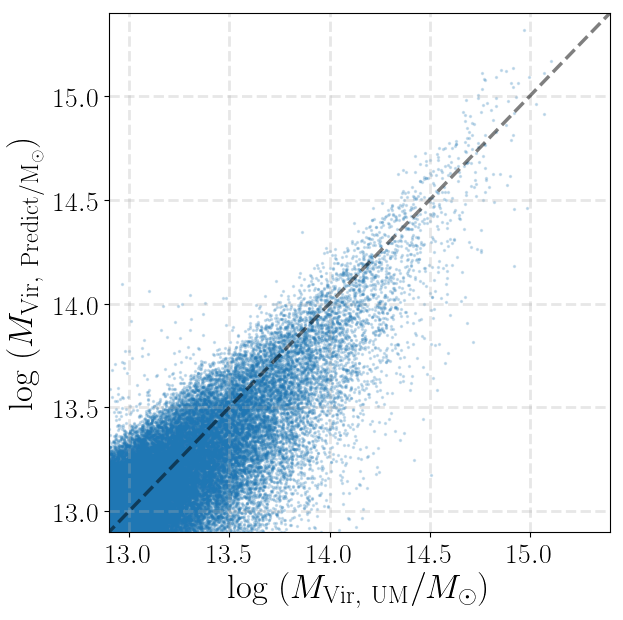

In [962]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax1.scatter(um_more['logmh_vir'], 
            3.472 * (logms_mod_tot - 11.69) - 2.748 * (logms_mod_inn - 11.34) + 13.6426,
            s=2, alpha=0.2)

ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.9, 15.4)
ax1.set_ylim(12.9, 15.4) 

ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ UM}/M_{\odot})$', fontsize=25)
ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ Predict/M_{\odot}})$', fontsize=25)

Text(0,0.5,'$\\log\\ (M_{\\rm Vir,\\ Scaling/M_{\\odot}})$')

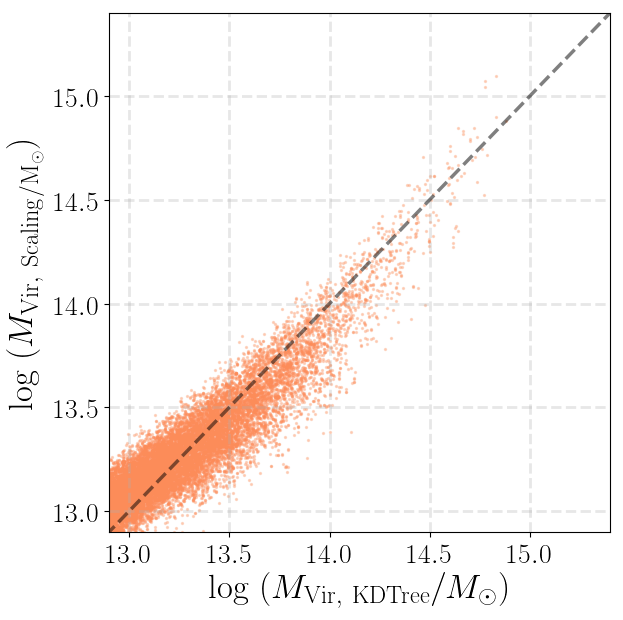

In [1003]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax1.scatter(mass_mh['logmh_vir_tree'], 
            3.472 * (mass_mh['logm_max'] - 11.69) - 2.748 * (mass_mh['logm_10'] - 11.34) + 13.6426,
            s=2, alpha=0.3, c=ORG(0.5))
    
ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.9, 15.4)
ax1.set_ylim(12.9, 15.4) 

ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ KDTree}/M_{\odot})$', fontsize=25)
ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ Scaling/M_{\odot}})$', fontsize=25)

In [1005]:
mass_mh.add_column(Column(data=3.472 * (mass_mh['logm_max'] - 11.69) - 2.748 * (mass_mh['logm_10'] - 11.34) + 13.6426,
                          name='logmh_vir_scale'))

In [1044]:
mass_mh.write(os.path.join(um_dir, 's16a_mass_good_mhalo_frac4_180503.fits'),
              format='fits', overwrite=True)

### Try more complex relation using symbolic regression

In [1013]:
from gplearn.genetic import SymbolicRegressor

In [1038]:
um_mvir = um_more_cen['logmh_vir']
mtot_mask = logms_mod_tot[central_only] >= 11.4

est_gp = SymbolicRegressor(population_size=5000, 
                           const_range=(-20.0, 20.0),
                           metric='mean absolute error',
                           generations=120, stopping_criteria=0.01,
                           p_crossover=0.9, p_subtree_mutation=0.01,
                           p_hoist_mutation=0.01, p_point_mutation=0.01,
                           max_samples=0.95, verbose=1, n_jobs=-1,
                           parsimony_coefficient=0.001, 
                           random_state=0)

est_gp.fit(um_mass[mtot_mask], um_mvir[mtot_mask])

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13 394470767192685.3       63 0.2312350747788321 0.23160473089485173     11.06m
   1    22.52 8755.902466428448       63 0.23095395796891513 0.23694250587372795     44.56m
   2    25.28 1314.641714392621       63 0.203795107093366 0.20176664258153276     63.81m
   3    34.53 230.57541417475036       63 0.20353022114296954 0.20679623009961656     77.08m
   4    36.04 130.97396591619997       65 0.1812537156426381 0.17975361447772414     89.36m
   5    25.26 43.73844143540863       65 0.18095480665653962 0.1854292228037746     98.18m
   6     21.7 35.5895630231904       93 0.16483390173953966 0.16526395015461423    103.05m
   7    27.18 11.60611470727586       59 0.16228597489930913 0.16326539134968435    106.08m
   8    32.82 14.876363

SymbolicRegressor(const_range=(-20.0, 20.0),
         function_set=('add', 'sub', 'mul', 'div'), generations=120,
         init_depth=(2, 6), init_method='half and half', max_samples=0.95,
         metric='mean absolute error', n_jobs=-1, p_crossover=0.9,
         p_hoist_mutation=0.01, p_point_mutation=0.01,
         p_point_replace=0.05, p_subtree_mutation=0.01,
         parsimony_coefficient=0.001, population_size=5000, random_state=0,
         stopping_criteria=0.01, tournament_size=20, verbose=1,
         warm_start=False)

In [1039]:
print est_gp._program

add(div(X1, X0), add(add(add(X1, X1), div(X1, 3.165)), sub(add(X1, -3.466), add(X0, X0))))


In [1043]:
mass_mh.add_column(Column(data=est_gp.predict(hsc_mass),
                          name='logmh_vir_symbol'))

Text(0,0.5,'$\\log\\ (M_{\\rm Vir,\\ Symbolic/M_{\\odot}})$')

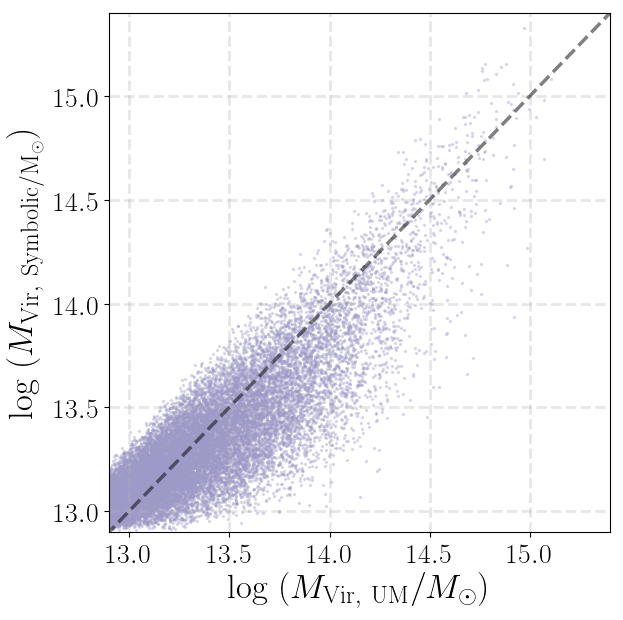

In [1040]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax1.scatter(um_mvir[mtot_mask], 
            est_gp.predict(um_mass[mtot_mask]),
            s=2, alpha=0.3, c=PUR(0.5))
    
ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.9, 15.4)
ax1.set_ylim(12.9, 15.4) 

ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ UM}/M_{\odot})$', fontsize=25)
ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ Symbolic/M_{\odot}})$', fontsize=25)

Text(0,0.5,'$\\log\\ (M_{\\rm Vir,\\ Symbolic/M_{\\odot}})$')

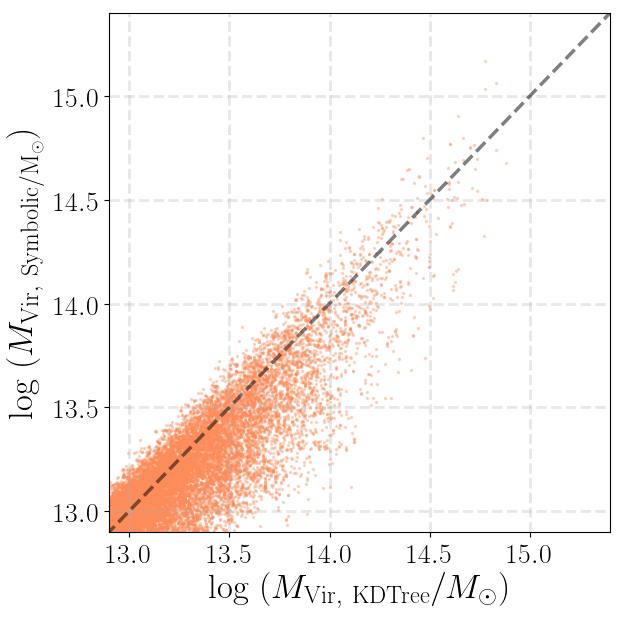

In [1042]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax1.scatter(mass_mh['logmh_vir_tree'], 
            est_gp.predict(hsc_mass),
            s=2, alpha=0.3, c=ORG(0.5))
    
ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.9, 15.4)
ax1.set_ylim(12.9, 15.4) 

ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ KDTree}/M_{\odot})$', fontsize=25)
ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ Symbolic/M_{\odot}})$', fontsize=25)

### TopN DeltaSigma test using the model halo mass 

In [901]:
from asap.ellipse_selection_functions import ellipse_split_2d

from dsigma.stack_ds import stack_delta_sigma, batch_delta_sigma
from dsigma.plots import show_delta_sigma_profiles, show_r_delta_sigma

In [902]:
def rank_mask_desc(data, rank1, rank2, master_mask=None,
                   nan_replace=-999):
    """Mask for objects ranking between N1 and N2."""
    if np.any(~np.isfinite(data)):
        data = np.where(~np.isfinite(data), nan_replace, 
                        data)
        
    if master_mask is None:
        data_use = data
    else:
        data_use = data[master_mask]
        
    idx_sorted = np.argsort(data_use)[::-1]
    
    max_val = data_use[idx_sorted[rank1 - 1]]
    min_val = data_use[idx_sorted[rank2 - 1]]
    print(min_val, max_val)
    
    if master_mask is not None:
        return (data >= min_val) & (data <= max_val) & master_mask
    
    return (data >= min_val) & (data <= max_val)

In [905]:
sbp_dir = os.path.join(envir['s16a'], 'sbp')
sbp_cat_dir = os.path.join(envir['s16a'], 'sbp/catalog')
wl_dir = os.path.join(envir['s16a'], 'um2/s16a_massive_wl')

lens_data = np.load(
    os.path.join(wl_dir, 's16a_massive_prep_new.npy'))
lens_ds = np.load(
    os.path.join(wl_dir, 's16a_massive_ds_basic.npz'))
rand_ds = np.load(
    os.path.join(wl_dir, 's16a_randoms_ds_basic.npz'))

lens_prep = Table(lens_data)

print(len(lens_prep))

38000


In [1045]:
# Assign halo mass 
master_mask = np.asarray([obj['object_id'] in mass_good['object_id'] for obj in lens_prep])

lens_mass = np.stack((np.array(lens_prep['logm_10']),
                      np.array(lens_prep['logm_max'])), axis=-1)

# NearestNeighbor
mstar_tree = KDTree(um_mass, leaf_size=15, metric='minkowski')

mstar_dist, mstar_idx = mstar_tree.query(lens_mass, k=5)

mp_predict = np.asarray([np.nanmean(um_more_cen[idxs]['logmh_peak']) for idxs in mstar_idx])
mv_predict = np.asarray([np.nanmean(um_more_cen[idxs]['logmh_vir']) for idxs in mstar_idx])
rv_predict = np.asarray([np.nanmean(um_more_cen[idxs]['rvir']) for idxs in mstar_idx])
a50_predict = np.asarray([np.nanmean(um_more_cen[idxs]['a_50']) for idxs in mstar_idx])
alm_predict = np.asarray([np.nanmean(um_more_cen[idxs]['a_lmm']) for idxs in mstar_idx])

lens_mh = copy.deepcopy(lens_prep)
lens_mh.add_column(Column(data=mp_predict, name='logmh_peak_tree'))
lens_mh.add_column(Column(data=mv_predict, name='logmh_vir_tree'))
lens_mh.add_column(Column(data=rv_predict, name='rvir_tree'))
lens_mh.add_column(Column(data=a50_predict, name='a50_tree'))
lens_mh.add_column(Column(data=alm_predict, name='alm_tree'))

# RandomForest
mstar_forest = RandomForestRegressor(n_estimators=10, criterion='mse',
                                     max_depth=None, random_state=0)

mstar_forest.fit(um_mass, um_more_cen['logmh_vir'])
lens_mh.add_column(Column(data=mstar_forest.predict(lens_mass), name='logmh_vir_forest'))

# Scaling relation
mh_scaling = 3.711 * (lens_mh['logm_max'] - 11.59) - 2.971 * (lens_mh['logm_10'] - 11.29) + 13.431
#mh_scaling = 3.472 * (lens_mh['logm_max'] - 11.69) - 2.748 * (lens_mh['logm_10'] - 11.34) + 13.6426

lens_mh.add_column(Column(data=mh_scaling, name='logmh_vir_scale'))

# Symbolic regression
lens_mh.add_column(Column(data=est_gp.predict(lens_mass),
                          name='logmh_vir_symbol'))

#### Based on predicted halo mass

In [1074]:
# Predicted halo mass
logmh_1 = np.asarray(lens_mh['logmh_vir_tree'])
logmh_2 = np.asarray(lens_mh['logmh_vir_forest'])
logmh_3 = np.asarray(lens_mh['logmh_vir_scale'])
logmh_4 = np.asarray(lens_mh['logmh_vir_symbol'])

# logMh > 14.2
mh1_mask_1 = (logmh_1 >= 14.2) & master_mask
mh2_mask_1 = (logmh_2 >= 14.2) & master_mask
mh3_mask_1 = (logmh_3 >= 14.2) & master_mask
mh4_mask_1 = (logmh_4 >= 14.2) & master_mask

# 14.0 < logMh < 14.2
mh1_mask_2 = (logmh_1 >= 14.0) & (logmh_1 < 14.2) & master_mask
mh2_mask_2 = (logmh_2 >= 14.0) & (logmh_2 < 14.2) & master_mask
mh3_mask_2 = (logmh_3 >= 14.0) & (logmh_3 < 14.2) & master_mask
mh4_mask_2 = (logmh_4 >= 14.0) & (logmh_4 < 14.2) & master_mask

# 13.8 < logMh < 14.0
mh1_mask_3 = (logmh_1 >= 13.8) & (logmh_1 < 14.0) & master_mask
mh2_mask_3 = (logmh_2 >= 13.8) & (logmh_2 < 14.0) & master_mask
mh3_mask_3 = (logmh_3 >= 13.8) & (logmh_3 < 14.0) & master_mask
mh4_mask_3 = (logmh_4 >= 13.8) & (logmh_4 < 14.0) & master_mask

# 13.5 < logMh < 13.8
mh1_mask_4 = (logmh_1 >= 13.5) & (logmh_1 < 13.8) & master_mask
mh2_mask_4 = (logmh_2 >= 13.5) & (logmh_2 < 13.8) & master_mask
mh3_mask_4 = (logmh_3 >= 13.5) & (logmh_3 < 13.8) & master_mask
mh4_mask_4 = (logmh_4 >= 13.5) & (logmh_4 < 13.8) & master_mask

# 13.2 < logMh < 13.5
mh1_mask_5 = (logmh_1 >= 13.2) & (logmh_1 < 13.5) & master_mask
mh2_mask_5 = (logmh_2 >= 13.2) & (logmh_2 < 13.5) & master_mask
mh3_mask_5 = (logmh_3 >= 13.2) & (logmh_3 < 13.5) & master_mask
mh4_mask_5 = (logmh_4 >= 13.2) & (logmh_4 < 13.5) & master_mask

# Sample: 247 / 38000 galaxies
# Number of useful jackknife regions: 40
# Sample: 277 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 233 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 168 / 38000 galaxies
# Number of useful jackknife regions: 40
(14.202527132647386, 15.169685725627904, 14.409882490624062)


Text(0.1,2,'$\\log M_{\\mathrm{vir}}: [14.2, 15.2]$')

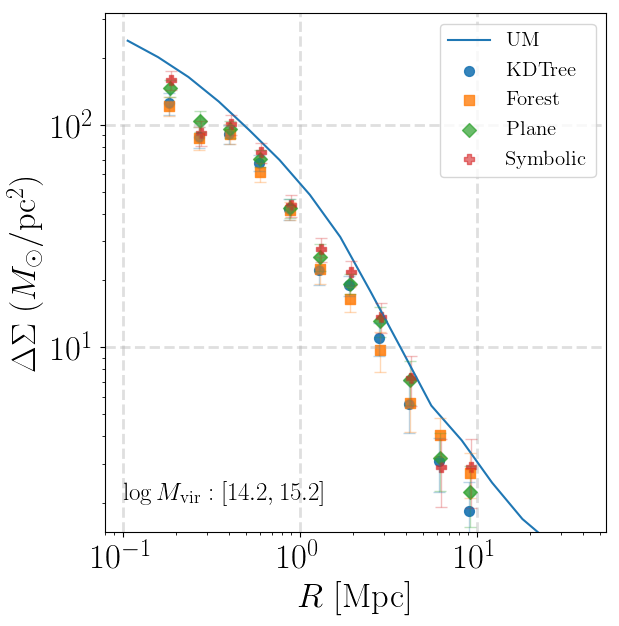

In [1070]:
logmh_bin_1 = batch_delta_sigma(
    lens_prep, lens_ds, 
    [mh1_mask_1, mh2_mask_1, mh3_mask_1, mh4_mask_1], 
    rand_ds=rand_ds, njackknife_fields=41) 

print(np.nanmin(lens_mh[mh4_mask_1]['logmh_vir_symbol']),
      np.nanmax(lens_mh[mh4_mask_1]['logmh_vir_symbol']),
      np.nanmean(lens_mh[mh4_mask_1]['logmh_vir_symbol']))

label_list = ['KDTree', 'Forest', 'Plane', 'Symbolic']

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

um_logmh_mask_1 = (um_more['logmh_vir'] >= 14.2) & (um_more['logmh_vir'] < 15.2) & (um_more['upid'] == -1)
um_logmh_dsig_1 = asap_um_dsigma(cfg_use, um_more[um_logmh_mask_1], um_dsig[um_logmh_mask_1, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)
ax1.plot(um_rp_phy, um_logmh_dsig_1, label='UM')

ax1 = show_delta_sigma_profiles(logmh_bin_1, ax=ax1,
                                list_label=label_list,
                                legend_size=15)

ax1.text(0.1, 2.0, '$\log M_{\mathrm{vir}}: [14.2, 15.2]$', fontsize=18)

# Sample: 359 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 368 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 270 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 214 / 38000 galaxies
# Number of useful jackknife regions: 40
(14.000967245578186, 14.19945558946267, 14.090703144700637)


Text(0.1,2,'$\\log M_{\\mathrm{vir}}: [14.0, 14.2]$')

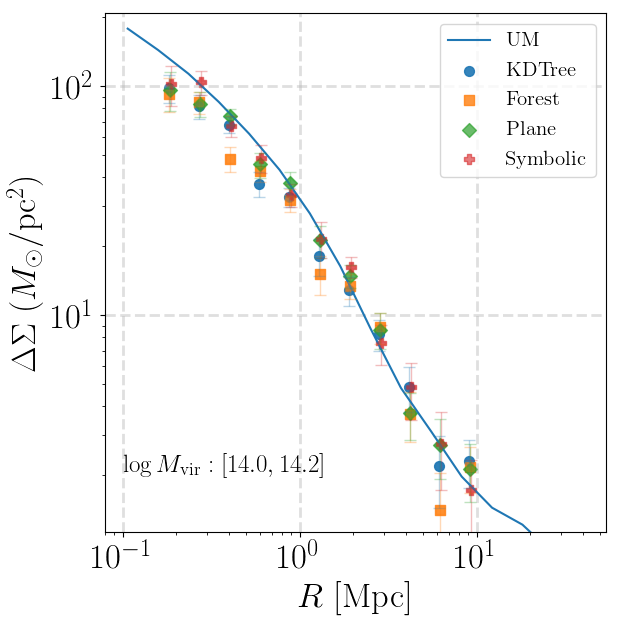

In [1071]:
logmh_bin_2 = batch_delta_sigma(
    lens_prep, lens_ds, 
    [mh1_mask_2, mh2_mask_2, mh3_mask_2, mh4_mask_2], 
    rand_ds=rand_ds, njackknife_fields=41) 

print(np.nanmin(lens_mh[mh4_mask_2]['logmh_vir_symbol']),
      np.nanmax(lens_mh[mh4_mask_2]['logmh_vir_symbol']),
      np.nanmean(lens_mh[mh4_mask_2]['logmh_vir_symbol']))

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

um_logmh_mask_2 = (um_more['logmh_vir'] >= 14.0) & (um_more['logmh_vir'] < 14.2) & (um_more['upid'] == -1)
um_logmh_dsig_2 = asap_um_dsigma(cfg_use, um_more[um_logmh_mask_2], um_dsig[um_logmh_mask_2, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)
ax1.plot(um_rp_phy, um_logmh_dsig_2, label='UM')

ax1 = show_delta_sigma_profiles(logmh_bin_2, ax=ax1,
                                list_label=label_list,
                                legend_size=15)

ax1.text(0.1, 2.0, '$\log M_{\mathrm{vir}}: [14.0, 14.2]$', fontsize=18)

# Sample: 855 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 842 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 576 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 495 / 38000 galaxies
# Number of useful jackknife regions: 41
(13.800274662385762, 13.999321087638428, 13.886738504320219)


Text(0.1,2,'$\\log M_{\\mathrm{vir}}: [13.8, 14.0]$')

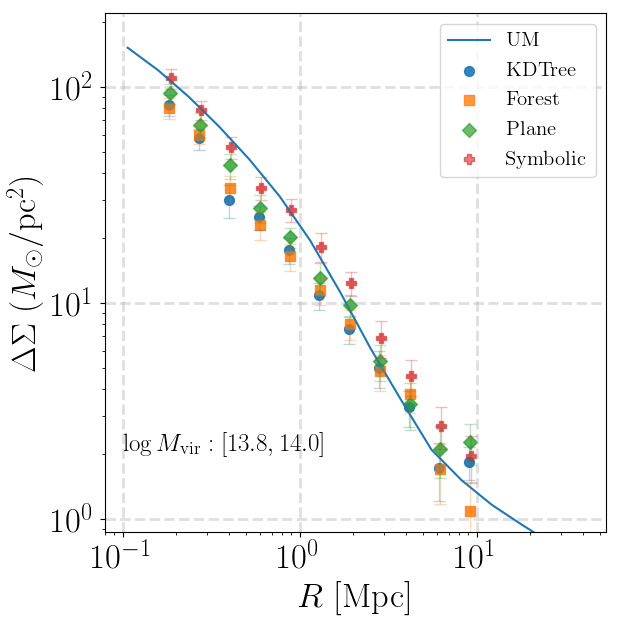

In [1072]:
logmh_bin_3 = batch_delta_sigma(
    lens_prep, lens_ds, 
    [mh1_mask_3, mh2_mask_3, mh3_mask_3, mh4_mask_3], 
    rand_ds=rand_ds, njackknife_fields=41) 

print(np.nanmin(lens_mh[mh4_mask_3]['logmh_vir_symbol']),
      np.nanmax(lens_mh[mh4_mask_3]['logmh_vir_symbol']),
      np.nanmean(lens_mh[mh4_mask_3]['logmh_vir_symbol']))

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

um_logmh_mask_3 = (um_more['logmh_vir'] >= 13.8) & (um_more['logmh_vir'] < 14.0) & (um_more['upid'] == -1)
um_logmh_dsig_3 = asap_um_dsigma(cfg_use, um_more[um_logmh_mask_3], um_dsig[um_logmh_mask_3, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)
ax1.plot(um_rp_phy, um_logmh_dsig_3, label='UM')

ax1 = show_delta_sigma_profiles(logmh_bin_3, ax=ax1,
                                list_label=label_list,
                                legend_size=15)

ax1.text(0.1, 1.2, '$\log M_{\mathrm{vir}}: [13.8, 14.0]$', fontsize=18)

# Sample: 2582 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 2627 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 2439 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 1782 / 38000 galaxies
# Number of useful jackknife regions: 41
(13.50006333934935, 13.799857724226658, 13.624120040769272)


Text(0.1,2,'$\\log M_{\\mathrm{vir}}: [13.5, 13.8]$')

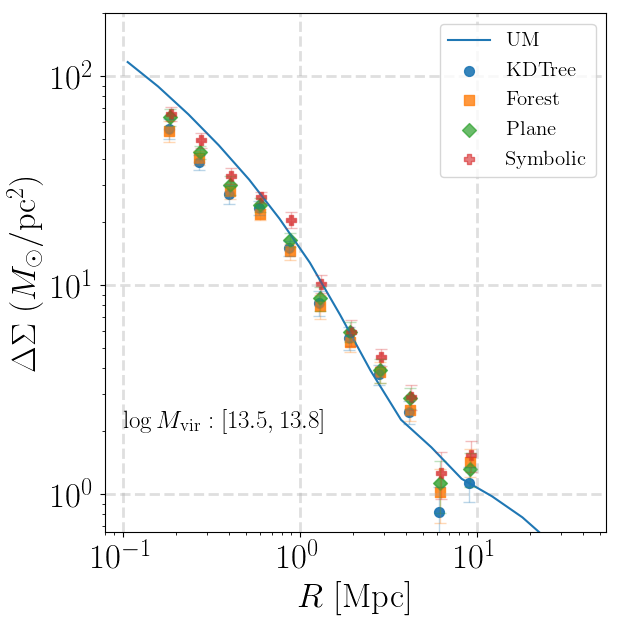

In [1073]:
logmh_bin_4 = batch_delta_sigma(
    lens_prep, lens_ds, 
    [mh1_mask_4, mh2_mask_4, mh3_mask_4, mh4_mask_4], 
    rand_ds=rand_ds, njackknife_fields=41) 

print(np.nanmin(lens_mh[mh4_mask_4]['logmh_vir_symbol']),
      np.nanmax(lens_mh[mh4_mask_4]['logmh_vir_symbol']),
      np.nanmean(lens_mh[mh4_mask_4]['logmh_vir_symbol']))

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

um_logmh_mask_4 = (um_more['logmh_vir'] >= 13.5) & (um_more['logmh_vir'] < 13.8) & (um_more['upid'] == -1)
um_logmh_dsig_4 = asap_um_dsigma(cfg_use, um_more[um_logmh_mask_4], um_dsig[um_logmh_mask_4, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)
ax1.plot(um_rp_phy, um_logmh_dsig_4, label='UM')

ax1 = show_delta_sigma_profiles(logmh_bin_4, ax=ax1,
                                list_label=label_list,
                                legend_size=15)

ax1.text(0.1, 1.0, '$\log M_{\mathrm{vir}}: [13.5, 13.8]$', fontsize=18)

# Sample: 5206 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 5174 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 6094 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 4606 / 38000 galaxies
# Number of useful jackknife regions: 41
(13.200003539862053, 13.499972867958284, 13.329856303585595)


Text(0.1,1,'$\\log M_{\\mathrm{vir}}: [13.2, 13.5]$')

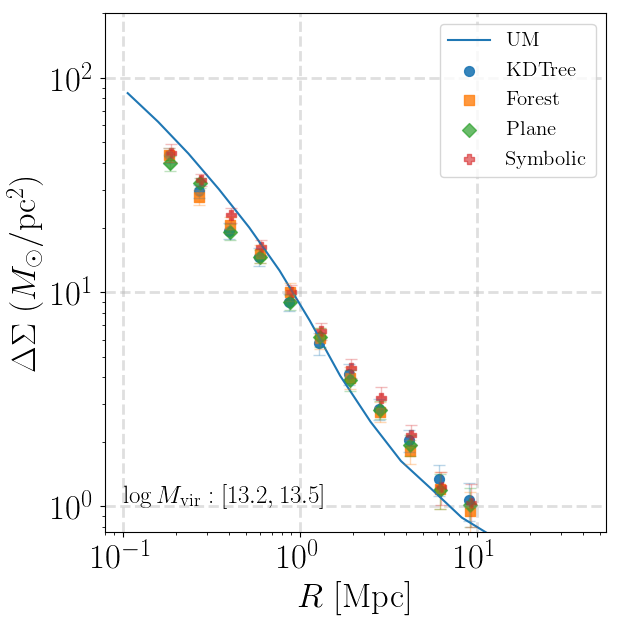

In [1075]:
logmh_bin_5 = batch_delta_sigma(
    lens_prep, lens_ds, 
    [mh1_mask_5, mh2_mask_5, mh3_mask_5, mh4_mask_5], 
    rand_ds=rand_ds, njackknife_fields=41) 

print(np.nanmin(lens_mh[mh4_mask_5]['logmh_vir_symbol']),
      np.nanmax(lens_mh[mh4_mask_5]['logmh_vir_symbol']),
      np.nanmean(lens_mh[mh4_mask_5]['logmh_vir_symbol']))

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

um_logmh_mask_5 = (um_more['logmh_vir'] >= 13.2) & (um_more['logmh_vir'] < 13.5) & (um_more['upid'] == -1)
um_logmh_dsig_5 = asap_um_dsigma(cfg_use, um_more[um_logmh_mask_5], um_dsig[um_logmh_mask_5, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)
ax1.plot(um_rp_phy, um_logmh_dsig_5, label='UM')

ax1 = show_delta_sigma_profiles(logmh_bin_5, ax=ax1,
                                list_label=label_list,
                                legend_size=15)

ax1.text(0.1, 1.0, '$\log M_{\mathrm{vir}}: [13.2, 13.5]$', fontsize=18)

#### Based on ranking

In [1083]:
# Richness
red_rich = np.asarray(lens_mh['lambda_redm'])
cam_rich = np.asarray(lens_mh['n_cor_camira'])

# Stellar mass 
logms_1 = np.asarray(lens_mh['logm_max'])


# KDTree
logmh_1_mask_1 = rank_mask_desc(
    logmh_1, 1, 30, master_mask=master_mask)
logmh_1_mask_2 = rank_mask_desc(
    logmh_1, 1, 50, master_mask=master_mask)
logmh_1_mask_3 = rank_mask_desc(
    logmh_1, 1, 100, master_mask=master_mask)
logmh_1_mask_4 = rank_mask_desc(
    logmh_1, 1, 200, master_mask=master_mask)
logmh_1_mask_5 = rank_mask_desc(
    logmh_1, 50, 100, master_mask=master_mask)
logmh_1_mask_6 = rank_mask_desc(
    logmh_1, 100, 200, master_mask=master_mask)

# RandomForest
logmh_2_mask_1 = rank_mask_desc(
    logmh_2, 1, 30, master_mask=master_mask)
logmh_2_mask_2 = rank_mask_desc(
    logmh_2, 1, 50, master_mask=master_mask)
logmh_2_mask_3 = rank_mask_desc(
    logmh_2, 1, 100, master_mask=master_mask)
logmh_2_mask_4 = rank_mask_desc(
    logmh_2, 1, 200, master_mask=master_mask)
logmh_2_mask_5 = rank_mask_desc(
    logmh_2, 50, 100, master_mask=master_mask)
logmh_2_mask_6 = rank_mask_desc(
    logmh_2, 100, 200, master_mask=master_mask)

# Plane
logmh_3_mask_1 = rank_mask_desc(
    logmh_3, 1, 30, master_mask=master_mask)
logmh_3_mask_2 = rank_mask_desc(
    logmh_3, 1, 50, master_mask=master_mask)
logmh_3_mask_3 = rank_mask_desc(
    logmh_3, 1, 100, master_mask=master_mask)
logmh_3_mask_4 = rank_mask_desc(
    logmh_3, 1, 200, master_mask=master_mask)
logmh_3_mask_5 = rank_mask_desc(
    logmh_3, 50, 100, master_mask=master_mask)
logmh_3_mask_6 = rank_mask_desc(
    logmh_3, 100, 200, master_mask=master_mask)

# Symbolic regression
logmh_4_mask_1 = rank_mask_desc(
    logmh_4, 1, 30, master_mask=master_mask)
logmh_4_mask_2 = rank_mask_desc(
    logmh_4, 1, 50, master_mask=master_mask)
logmh_4_mask_3 = rank_mask_desc(
    logmh_4, 1, 100, master_mask=master_mask)
logmh_4_mask_4 = rank_mask_desc(
    logmh_4, 1, 200, master_mask=master_mask)
logmh_4_mask_5 = rank_mask_desc(
    logmh_4, 50, 100, master_mask=master_mask)
logmh_4_mask_6 = rank_mask_desc(
    logmh_4, 100, 200, master_mask=master_mask)

# Maximum 1-D stellar mass
logms_1_mask_1 = rank_mask_desc(
    logms_1, 1, 30, master_mask=master_mask)
logms_1_mask_2 = rank_mask_desc(
    logms_1, 1, 50, master_mask=master_mask)
logms_1_mask_3 = rank_mask_desc(
    logms_1, 1, 100, master_mask=master_mask)
logms_1_mask_4 = rank_mask_desc(
    logms_1, 1, 200, master_mask=master_mask)
logms_1_mask_5 = rank_mask_desc(
    logms_1, 50, 100, master_mask=master_mask)
logms_1_mask_6 = rank_mask_desc(
    logms_1, 100, 200, master_mask=master_mask)

# redMaPPer
red_rich_mask_1 = rank_mask_desc(
    red_rich, 1, 30, master_mask=master_mask)
red_rich_mask_2 = rank_mask_desc(
    red_rich, 1, 50, master_mask=master_mask)
red_rich_mask_3 = rank_mask_desc(
    red_rich, 1, 100, master_mask=master_mask)
red_rich_mask_4 = rank_mask_desc(
    red_rich, 1, 200, master_mask=master_mask)
red_rich_mask_5 = rank_mask_desc(
    red_rich, 50, 100, master_mask=master_mask)
red_rich_mask_6 = rank_mask_desc(
    red_rich, 100, 200, master_mask=master_mask)

# CAMIRA
cam_rich_mask_1 = rank_mask_desc(
    cam_rich, 1, 30, master_mask=master_mask)
cam_rich_mask_2 = rank_mask_desc(
    cam_rich, 1, 50, master_mask=master_mask)
cam_rich_mask_3 = rank_mask_desc(
    cam_rich, 1, 100, master_mask=master_mask)
cam_rich_mask_4 = rank_mask_desc(
    cam_rich, 1, 200, master_mask=master_mask)
cam_rich_mask_5 = rank_mask_desc(
    cam_rich, 50, 100, master_mask=master_mask)
cam_rich_mask_6 = rank_mask_desc(
    cam_rich, 100, 200, master_mask=master_mask)

(14.59126651962028, 14.881803340273411)
(14.527689364213558, 14.881803340273411)
(14.372718110553157, 14.881803340273411)
(14.244230921236428, 14.881803340273411)
(14.372718110553157, 14.527689364213558)
(14.244230921236428, 14.372718110553157)
(14.60511045565118, 14.964403804059083)
(14.521634497177, 14.964403804059083)
(14.385691043480026, 14.964403804059083)
(14.263384778001832, 14.964403804059083)
(14.385691043480026, 14.521634497177)
(14.263384778001832, 14.385691043480026)
(14.693086926352088, 15.209911776848806)
(14.578570780307198, 15.209911776848806)
(14.400327120504446, 15.209911776848806)
(14.238073338409786, 15.209911776848806)
(14.400327120504446, 14.578570780307198)
(14.238073338409786, 14.400327120504446)
(14.574221494995204, 15.169685725627904)
(14.473673556744455, 15.169685725627904)
(14.319338885817997, 15.169685725627904)
(14.157067962734905, 15.169685725627904)
(14.319338885817997, 14.473673556744455)
(14.157067962734905, 14.319338885817997)
(12.001885015484113, 12.

In [1077]:
logmh_1_list = [logmh_1_mask_1, logmh_1_mask_2, logmh_1_mask_3, logmh_1_mask_4,
                logmh_1_mask_5, logmh_1_mask_6]

logmh_1_dsig = batch_delta_sigma(
    lens_prep, lens_ds, logmh_1_list, rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 30 / 38000 galaxies
# Number of useful jackknife regions: 18
# Sample: 50 / 38000 galaxies
# Number of useful jackknife regions: 27
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 35
# Sample: 200 / 38000 galaxies
# Number of useful jackknife regions: 40
# Sample: 51 / 38000 galaxies
# Number of useful jackknife regions: 27
# Sample: 101 / 38000 galaxies
# Number of useful jackknife regions: 36


In [1078]:
logmh_2_list = [logmh_2_mask_1, logmh_2_mask_2, logmh_2_mask_3, logmh_2_mask_4,
                logmh_2_mask_5, logmh_2_mask_6]

logmh_2_dsig = batch_delta_sigma(
    lens_prep, lens_ds, logmh_2_list, rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 30 / 38000 galaxies
# Number of useful jackknife regions: 20
# Sample: 50 / 38000 galaxies
# Number of useful jackknife regions: 28
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 37
# Sample: 200 / 38000 galaxies
# Number of useful jackknife regions: 38
# Sample: 51 / 38000 galaxies
# Number of useful jackknife regions: 29
# Sample: 101 / 38000 galaxies
# Number of useful jackknife regions: 36


In [1079]:
logmh_3_list = [logmh_3_mask_1, logmh_3_mask_2, logmh_3_mask_3, logmh_3_mask_4,
                logmh_3_mask_5, logmh_3_mask_6]

logmh_3_dsig = batch_delta_sigma(
    lens_prep, lens_ds, logmh_3_list, rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 30 / 38000 galaxies
# Number of useful jackknife regions: 21
# Sample: 50 / 38000 galaxies
# Number of useful jackknife regions: 29
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 37
# Sample: 200 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 51 / 38000 galaxies
# Number of useful jackknife regions: 27
# Sample: 101 / 38000 galaxies
# Number of useful jackknife regions: 35


In [1080]:
logmh_4_list = [logmh_4_mask_1, logmh_4_mask_2, logmh_4_mask_3, logmh_4_mask_4,
                logmh_4_mask_5, logmh_4_mask_6]

logmh_4_dsig = batch_delta_sigma(
    lens_prep, lens_ds, logmh_4_list, rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 30 / 38000 galaxies
# Number of useful jackknife regions: 22
# Sample: 50 / 38000 galaxies
# Number of useful jackknife regions: 27
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 35
# Sample: 200 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 51 / 38000 galaxies
# Number of useful jackknife regions: 31
# Sample: 101 / 38000 galaxies
# Number of useful jackknife regions: 40


In [1081]:
logms_1_list = [logms_1_mask_1, logms_1_mask_2, logms_1_mask_3, logms_1_mask_4,
                logms_1_mask_5, logms_1_mask_6]

logms_1_dsig = batch_delta_sigma(
    lens_prep, lens_ds, logms_1_list, rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 30 / 38000 galaxies
# Number of useful jackknife regions: 23
# Sample: 50 / 38000 galaxies
# Number of useful jackknife regions: 30
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 35
# Sample: 200 / 38000 galaxies
# Number of useful jackknife regions: 40
# Sample: 51 / 38000 galaxies
# Number of useful jackknife regions: 25
# Sample: 101 / 38000 galaxies
# Number of useful jackknife regions: 38


In [1084]:
red_rich_list = [red_rich_mask_1, red_rich_mask_2, red_rich_mask_3, red_rich_mask_4,
                red_rich_mask_5, red_rich_mask_6]

red_rich_dsig = batch_delta_sigma(
    lens_prep, lens_ds, red_rich_list, rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 30 / 38000 galaxies
# Number of useful jackknife regions: 21
# Sample: 50 / 38000 galaxies
# Number of useful jackknife regions: 27
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 37
# Sample: 200 / 38000 galaxies
# Number of useful jackknife regions: 39
# Sample: 51 / 38000 galaxies
# Number of useful jackknife regions: 28
# Sample: 101 / 38000 galaxies
# Number of useful jackknife regions: 36


In [1085]:
cam_rich_list = [cam_rich_mask_1, cam_rich_mask_2, cam_rich_mask_3, cam_rich_mask_4,
                cam_rich_mask_5, cam_rich_mask_6]

cam_rich_dsig = batch_delta_sigma(
    lens_prep, lens_ds, cam_rich_list, rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 30 / 38000 galaxies
# Number of useful jackknife regions: 18
# Sample: 50 / 38000 galaxies
# Number of useful jackknife regions: 26
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 34
# Sample: 200 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 51 / 38000 galaxies
# Number of useful jackknife regions: 28
# Sample: 101 / 38000 galaxies
# Number of useful jackknife regions: 39


Text(0.2,3,'Top\\ 100')

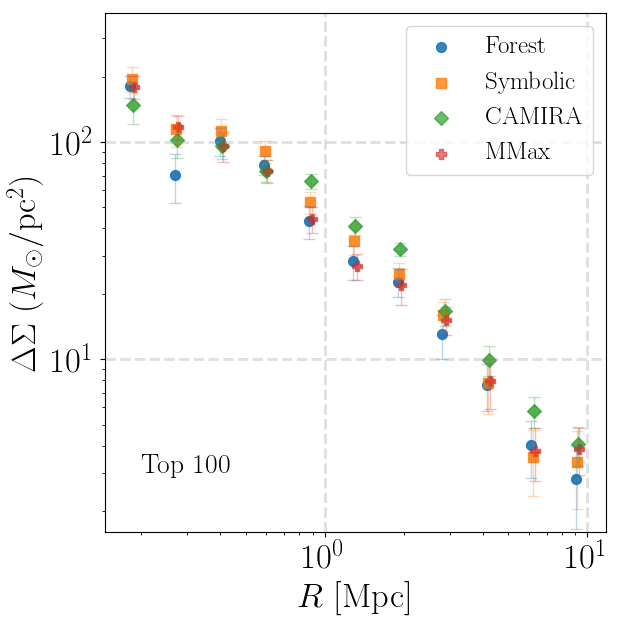

In [1105]:
#label_list = ['KDTree', 'Forest', 'Plane', 'Symbolic',
#              'redMaPPer', 'CAMIRA', 'MMax']
label_list = ['Forest', 'Symbolic',
               'CAMIRA', 'MMax']

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1 = show_delta_sigma_profiles([logmh_2_dsig[2],
                                 logmh_4_dsig[2],
                                 cam_rich_dsig[2],
                                 logms_1_dsig[2]], ax=ax1,
                                 list_label=label_list,
                                 legend_size=18)

ax1.text(0.2, 3.0, 'Top\ 100', fontsize=20)

#### Impact from redshift range and photometric quality

# Sample: 194 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 88 / 38000 galaxies
# Number of useful jackknife regions: 35
# Sample: 155 / 38000 galaxies
# Number of useful jackknife regions: 40


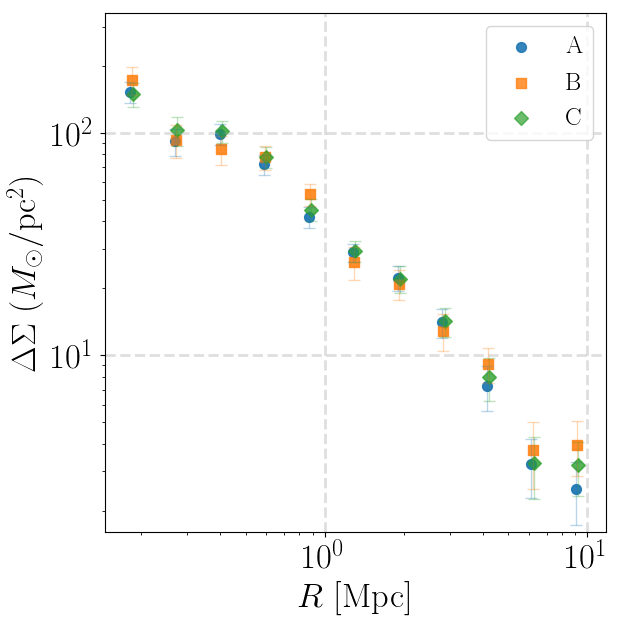

In [1111]:
mh4_mask_a = (logmh_4 >= 14.2)
mh4_mask_b = (logmh_4 >= 14.2) & (lens_prep['z'] <= 0.40) & (lens_prep['clean_photometry']) & master_mask
mh4_mask_c = (logmh_4 >= 14.2) & (lens_prep['z_spec'] >= 0.10) & (lens_prep['clean_photometry']) & master_mask

test_dsig = batch_delta_sigma(
    lens_prep, lens_ds, 
    [mh4_mask_a, mh4_mask_b, mh4_mask_c], 
    rand_ds=rand_ds, njackknife_fields=41) 


label_list = ['A', 'B', 'C']

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1 = show_delta_sigma_profiles(test_dsig, ax=ax1,
                                list_label=label_list,
                                legend_size=18)

(14.366072448759974, 15.434508232438922)
(14.16964024789062, 15.063027344196822)
(14.302096011265155, 15.169685725627904)
# Sample: 155 / 38000 galaxies
# Number of useful jackknife regions: 41
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 36
# Sample: 100 / 38000 galaxies
# Number of useful jackknife regions: 38


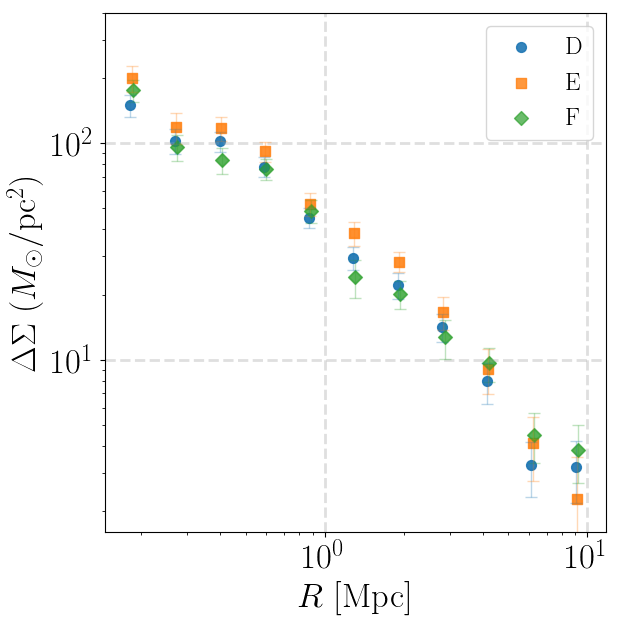

In [1112]:
mh4_mask_d = rank_mask_desc(
    logmh_4, 1, 100, master_mask=None)

mh4_mask_e = rank_mask_desc(
    logmh_4, 1, 100, master_mask=(master_mask & (lens_prep['z'] <= 0.40) & (lens_prep['clean_photometry'])))

mh4_mask_f = rank_mask_desc(
    logmh_4, 1, 100, master_mask=(master_mask & (lens_prep['z_spec'] > 0.10) & (lens_prep['clean_photometry'])))

test_dsig_2 = batch_delta_sigma(
    lens_prep, lens_ds, 
    [mh4_mask_c, mh4_mask_d, mh4_mask_e], 
    rand_ds=rand_ds, njackknife_fields=41) 

label_list = ['D', 'E', 'F']

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1 = show_delta_sigma_profiles(test_dsig_2, ax=ax1,
                                list_label=label_list,
                                legend_size=18)

### Split based on the Mmax-M10 distributions

185
(11.920902156830937, 11.359335570379118)
(14.412274822631446, 14.380949044278726)


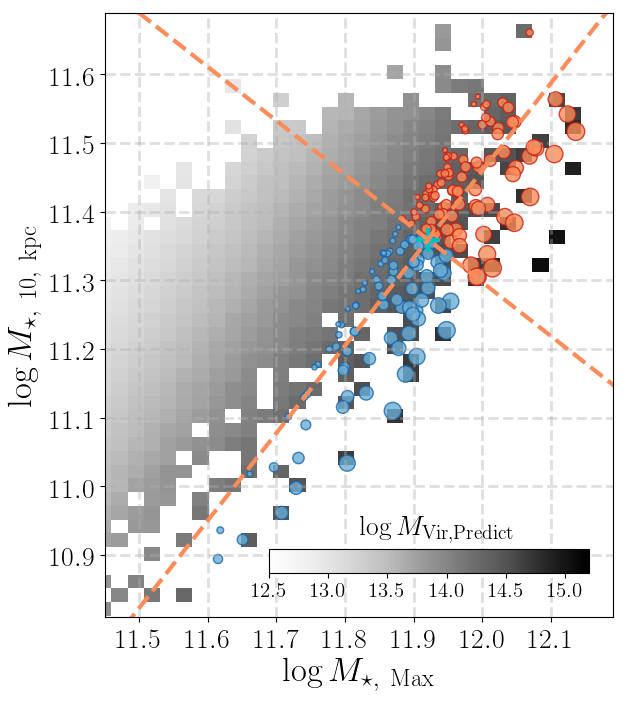

In [1241]:
mh_low, mh_upp = 14.2, 14.8
mh_col = 'logmh_vir_symbol'
ms_min = 11.6

sample_mask = ((lens_mh[mh_col] >= mh_low) & (lens_mh[mh_col] <= mh_upp) &
               (lens_mh['logm_max'] >= ms_min))
print(sample_mask.sum())

# Halo mass selected sample
sample_lens = lens_mh[sample_mask]
mtot_use = sample_lens['logm_max']
minn_use = sample_lens['logm_10']
mtot_minn_relation = np.polyfit(mtot_use, minn_use, 1)

mtot_med, minn_med = np.nanmedian(sample_lens['logm_max']), np.nanmedian(sample_lens['logm_10'])
print(mtot_med, minn_med)

# Intercept of the Mmax-M10 relation
slope_a = mtot_minn_relation[0]
intercept_a = minn_med - slope_a * mtot_med
slope_b = -1.0 / slope_a
intercept_b = minn_med - slope_b * mtot_med

# Group galaxies based on their location on the Mmax-M10 plane
upp_mask = (lens_mh['logm_10'] - (slope_b * lens_mh['logm_max'] + intercept_b) >= 0) & sample_mask
low_mask = (lens_mh['logm_10'] - (slope_b * lens_mh['logm_max'] + intercept_b) < 0) & sample_mask
print(np.nanmean(lens_mh[upp_mask][mh_col]),
      np.nanmean(lens_mh[low_mask][mh_col]))


# ---- #
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

## Mmax-M10-Mvir trend
x_arr = lens_mh[master_mask]['logm_max']
y_arr = lens_mh[master_mask]['logm_10']
z_arr = lens_mh[master_mask][mh_col]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 45))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.20,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

# Scatter plot for selected galaxies
ax1.scatter(lens_mh[upp_mask]['logm_max'], 
            lens_mh[upp_mask]['logm_10'],
            s=(lens_mh[upp_mask][mh_col] - mh_low + 0.04) * 260, 
            alpha=0.8, facecolor=ORG(0.5), edgecolor=ORG(0.8))

ax1.scatter(lens_mh[low_mask]['logm_max'], 
            lens_mh[low_mask]['logm_10'],
            s=(lens_mh[low_mask][mh_col] - mh_low + 0.04) * 260, 
            alpha=0.8, facecolor=BLU(0.5), edgecolor=BLU(0.8))

# Plot the Mmax-M10 relation
mtot_arr = np.linspace(11.4, 12.2, 100)
ax1.plot(mtot_arr, slope_a * mtot_arr + intercept_a, 
         linestyle='--', linewidth=3.0, c=ORG(0.5))
ax1.plot(mtot_arr, slope_b * mtot_arr + intercept_b, 
         linestyle='--', linewidth=3.0, c=ORG(0.5))
ax1.scatter(mtot_med, minn_med, s=300, marker='+', c='c', linewidth=3.0)

# ax1.legend(fontsize=15, loc='upper left')

## Colorbar
cax = fig.add_axes([0.40, 0.18, 0.40, 0.03])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.50, 0.13, r'$\log M_{\rm Vir, Predict}$', transform=ax1.transAxes, size=20)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)
ax1.set_aspect('equal')

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=25)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=25)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

In [1242]:
test_dsig_3 = batch_delta_sigma(
    lens_prep, lens_ds, 
    [upp_mask, low_mask], 
    rand_ds=rand_ds, njackknife_fields=41) 

# Sample: 95 / 38000 galaxies
# Number of useful jackknife regions: 38
# Sample: 90 / 38000 galaxies
# Number of useful jackknife regions: 36


Text(0.05,0.07,'$14.20 < \\log M_{\\rm Vir} < 14.80$')

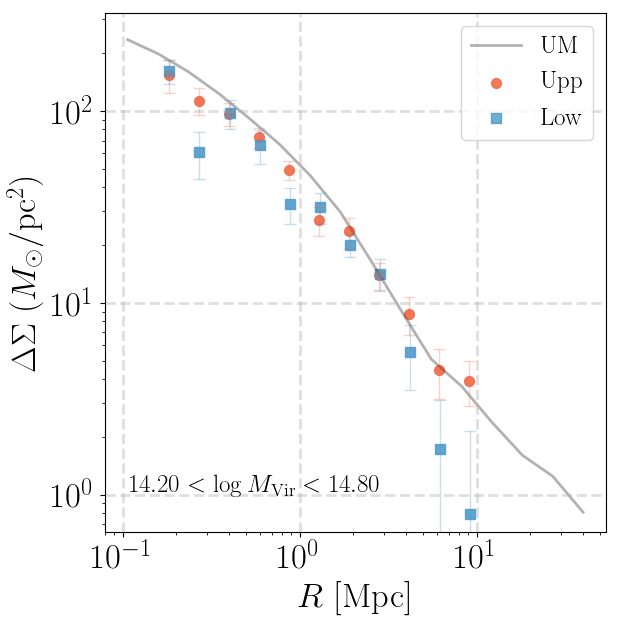

In [1243]:
label_list = ['Upp', 'Low']
color_list = [ORG(0.6), BLU(0.6)]

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

um_logmh_mask = (um_more['logmh_vir'] >= mh_low) & (um_more['logmh_vir'] < mh_upp) & (um_more['upid'] == -1)
um_logmh_dsig = asap_um_dsigma(cfg_use, um_more[um_logmh_mask], um_dsig[um_logmh_mask, :], 
                               mask=None, weight=None, r_interp=um_rp_phy)
ax1.plot(um_rp_phy, um_logmh_dsig, label='UM', c='k', alpha=0.3, linewidth=2.0, zorder=1)

ax1 = show_delta_sigma_profiles(test_dsig_3, ax=ax1,
                                list_label=label_list,
                                legend_size=18, 
                                c_list=color_list)

ax1.text(0.05, 0.07, r'$%4.2f < \log M_{\rm Vir} < %4.2f$' % (mh_low, mh_upp), 
         transform=ax1.transAxes, size=18)

### A few key figures to evaluate the model

In [72]:
obs_use = obs_mass[(obs_mass['r50_max'] >= 1.0) & 
                   (obs_mass['r50_max'] <= 35.0) &
                   (obs_mass['logm_max'] >= 11.4) & 
                   (obs_mass['logm_max'] <= 12.3) &
                   (obs_mass['logm_10'] >= 10.85) &
                   (obs_mass['logm_10'] <= 11.69)]

mask_mod = ((logms_mod_tot >= 11.45) & 
            (logms_mod_tot <= 12.20) & 
            (logms_mod_inn >= 10.65) & 
            (logms_mod_inn <= 11.70))

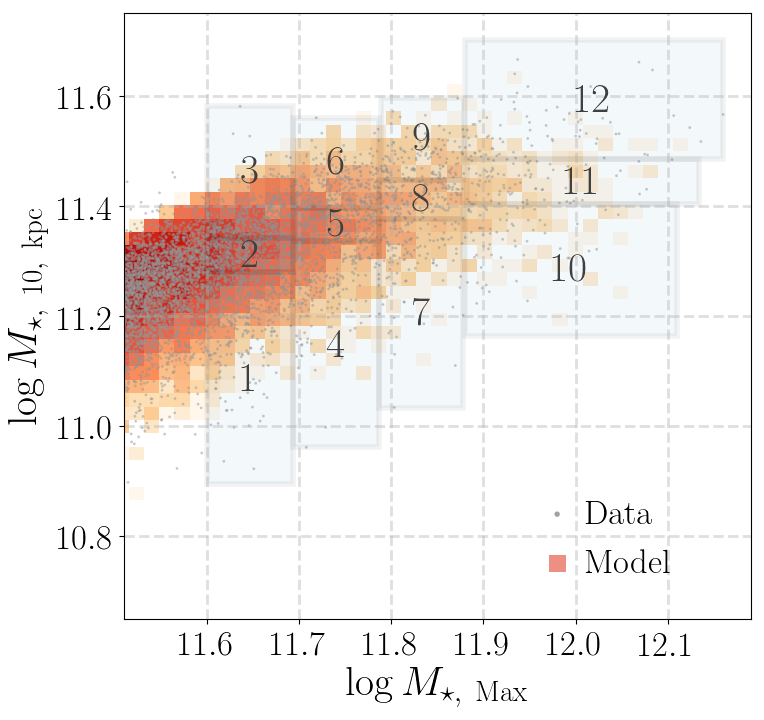

In [44]:
fig = plt.figure(figsize=(7.5, 7))

fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

## M100-M10 scatter plot
mask_mod = ((logms_mod_tot >= 11.45) & 
            (logms_mod_tot <= 12.20) & 
            (logms_mod_inn >= 10.65) & 
            (logms_mod_inn <= 11.70))

x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod]
z_arr = um_mock['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, 'count', bins=(45, 40))

z_img = z_stats.T
z_img[z_img <= 1] = 0
HM = ax1.imshow(np.log10(z_img), origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                aspect='auto', interpolation='nearest',
                cmap='OrRd', label=r'$\mathrm{Model}$')

ax1.scatter(obs_use['logm_max'], obs_use['logm_10'], s=4, alpha=0.5, 
            facecolor=BLK(0.5), edgecolor='none', label=r'$\mathrm{Data}$')

ax1.scatter(11.98, 10.84, marker='o', facecolor=BLK(0.6), s=15, edgecolor='None',
            alpha=0.7)
ax1.text(12.01, 10.84, r'$\mathrm{Data}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

ax1.scatter(11.98, 10.75, marker='s', facecolor=ORG(0.8), s=150, edgecolor='None',
            alpha=0.6)
ax1.text(12.01, 10.75, r'$\mathrm{Model}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

_ = ax1.set_xlim(11.51, 12.19)
_ = ax1.set_ylim(10.65, 11.75)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=30)

for ii in np.arange(12):
    obs_prof = obs_dsigma[ii]
    ax1.add_patch(
        patches.Rectangle(
            (obs_prof.low_mtot, obs_prof.low_minn),
            (obs_prof.upp_mtot - obs_prof.low_mtot),
            (obs_prof.upp_minn - obs_prof.low_minn), 
            alpha=0.05, edgecolor='k', linewidth=4))
    ax1.text((obs_prof.upp_mtot + obs_prof.low_mtot) / 2.0, 
             (obs_prof.upp_minn + obs_prof.low_minn) / 2.0,
             "%d" % (ii + 1), 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=30, color=BLK(0.8))

#fig.savefig('fig/mmax_m10_density_wlbin.pdf', dpi=150)

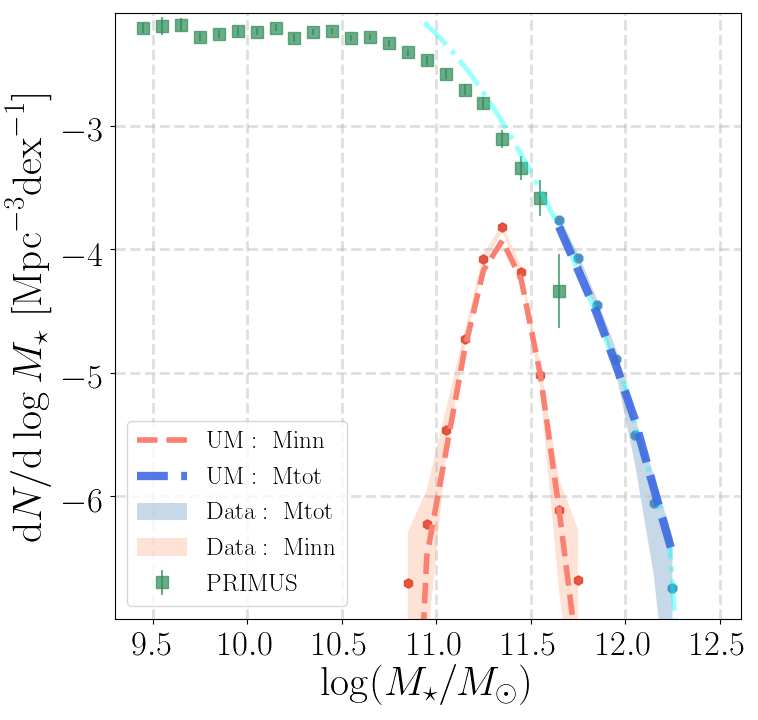

In [64]:
fig = plt.figure(figsize=(7.5, 7))

fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

obs_smf_tot = obs_data['obs_smf_tot']
obs_smf_inn = obs_data['obs_smf_inn']
obs_logms_tot = obs_data['obs_mtot']
obs_logms_inn = obs_data['obs_minn']
obs_smf_full = obs_data['obs_smf_full']
not_table = True


if obs_smf_full is not None:
    ax1.errorbar(obs_smf_full['logm_mean'] + 0.15,
                 np.log10(obs_smf_full['smf']),
                 (np.log10(obs_smf_full['smf_upp']) -
                  np.log10(obs_smf_full['smf'])),
                 fmt='o', color='seagreen',
                 ecolor='seagreen',
                 alpha=0.7, marker='s',
                 markersize=9,
                 label=r'$\mathrm{PRIMUS}$',
                 zorder=0)

um_smf_tot_all = get_smf_bootstrap(logms_mod_tot, cfg['um_volume'],
                                   21, 10.9, 12.5, n_boots=1)
if um_smf_tot_all is not None:
    ax1.plot(um_smf_tot_all['logm_mean'],
             np.log10(um_smf_tot_all['smf']),
             linewidth=3.5, linestyle='-.',
             c='cyan', alpha=0.4,
             label='__no_label__')

# SMF plot
ax1.fill_between(obs_smf_tot['logm_mean'],
                 np.log10(obs_smf_tot['smf_low']),
                 np.log10(obs_smf_tot['smf_upp']),
                 facecolor='steelblue',
                 edgecolor='none',
                 interpolate=True,
                 alpha=0.3,
                 label=r'$\mathrm{Data:\ Mtot}$')

ax1.fill_between(obs_smf_inn['logm_mean'],
                 np.log10(obs_smf_inn['smf_low']),
                 np.log10(obs_smf_inn['smf_upp']),
                 facecolor='lightsalmon',
                 edgecolor='none',
                 interpolate=True,
                 alpha=0.3,
                 label=r'$\mathrm{Data:\ Minn}$')

ax1.scatter(obs_smf_inn['logm_mean'],
            np.log10(obs_smf_inn['smf']),
            marker='h',
            c=ORG(0.8),
            s=45, label='__no_label__',
            alpha=0.9)

ax1.scatter(obs_smf_tot['logm_mean'],
            np.log10(obs_smf_tot['smf']),
            marker='8',
            c=BLU(0.8),
            s=45, label='__no_label__',
            alpha=1.0)

if isinstance(um_smf_inn, (list,)):
    for ii, smf in enumerate(um_smf_inn):
        if ii == 0:
            if not_table:
                ax1.plot(obs_smf_inn['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label=r'$\mathrm{UM:\ Minn}$')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label=r'$\mathrm{UM:\ Minn}$')
        else:
            if not_table:
                ax1.plot(obs_smf_inn['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label='__no_label__')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label='__no_label__')
else:
    if not_table:
        ax1.plot(obs_smf_inn['logm_mean'],
                 np.log10(um_smf_inn),
                 linewidth=4, linestyle='--',
                 c='salmon',
                 label=r'$\mathrm{UM:\ Minn}$')
    else:
        ax1.plot(um_smf_inn['logm_mean'],
                 np.log10(um_smf_inn['smf']),
                 linewidth=4, linestyle='--',
                 c='salmon',
                 label=r'$\mathrm{UM:\ Minn}$')

if isinstance(um_smf_tot, (list,)):
    for ii, smf in enumerate(um_smf_tot):
        if ii == 0:
            if not_table:
                ax1.plot(obs_smf_tot['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label=r'$\mathrm{UM:\ Mtot}$')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label=r'$\mathrm{UM:\ Mtot}$')
        else:
            if not_table:
                ax1.plot(obs_smf_tot['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label='__no_label__')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label='__no_label__')
else:
    if not_table:
        ax1.plot(obs_smf_tot['logm_mean'],
                 np.log10(um_smf_tot),
                 linewidth=6, linestyle='--',
                 c='royalblue', alpha=0.9,
                 label=r'$\mathrm{UM:\ Mtot}$')
    else:
        ax1.plot(um_smf_tot['logm_mean'],
                 np.log10(um_smf_tot['smf']),
                 linewidth=6, linestyle='--',
                 c='royalblue', alpha=0.9,
                 label=r'$\mathrm{UM:\ Mtot}$')

ax1.legend(fontsize=18, loc='lower left')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
               fontsize=30)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
               size=30)

mask_inn = np.log10(obs_smf_inn['smf']) > -7.5
mask_tot = np.log10(obs_smf_tot['smf']) > -7.5

#_ = ax1.set_xlim(10.75, 12.29)
_ = ax1.set_ylim(-6.99, -2.09)

#fig.savefig('fig/mmax_m10_mod_smfs.pdf', dpi=150)

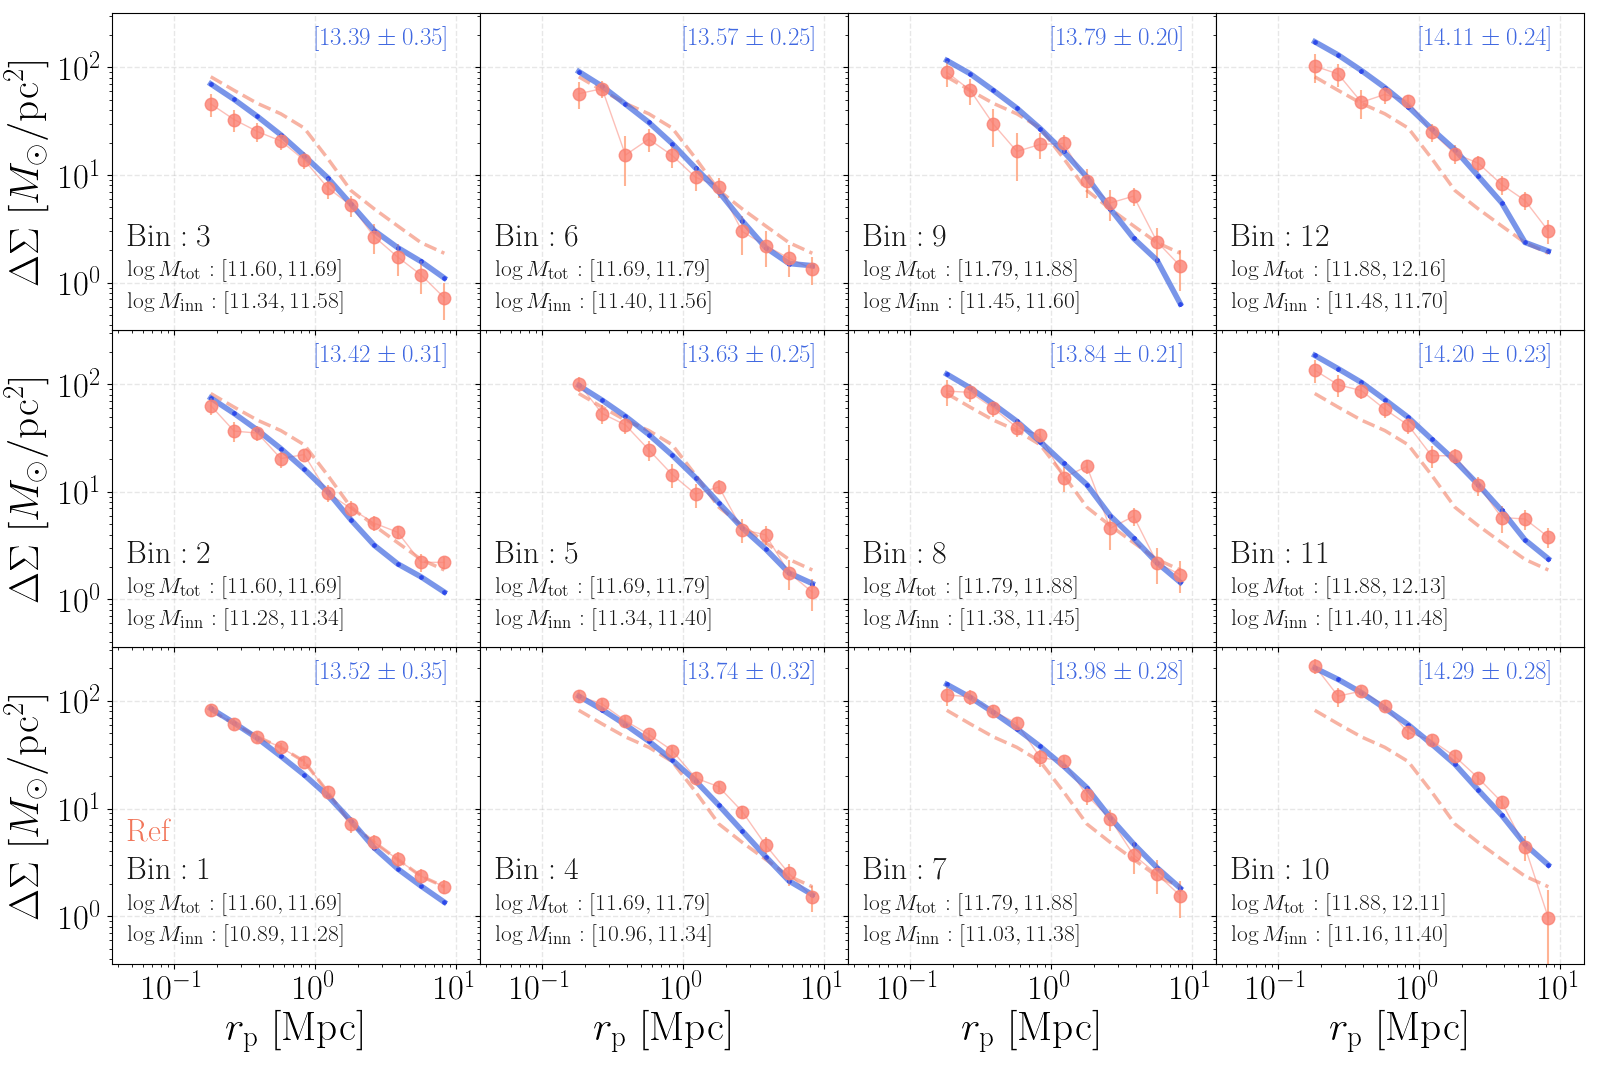

In [71]:
um_mhalo_tuple = asap_predict_mhalo(obs_data['obs_wl_dsigma'], 
                                    um_data['um_mock'],
                                    logms_mod_tot, logms_mod_inn)

mod_dsig = plot_dsigma_profiles(obs_data['obs_wl_dsigma'],
                                um_dsigma, obs_mhalo=None, um_mhalo=um_mhalo_tuple,
                                reference=0)

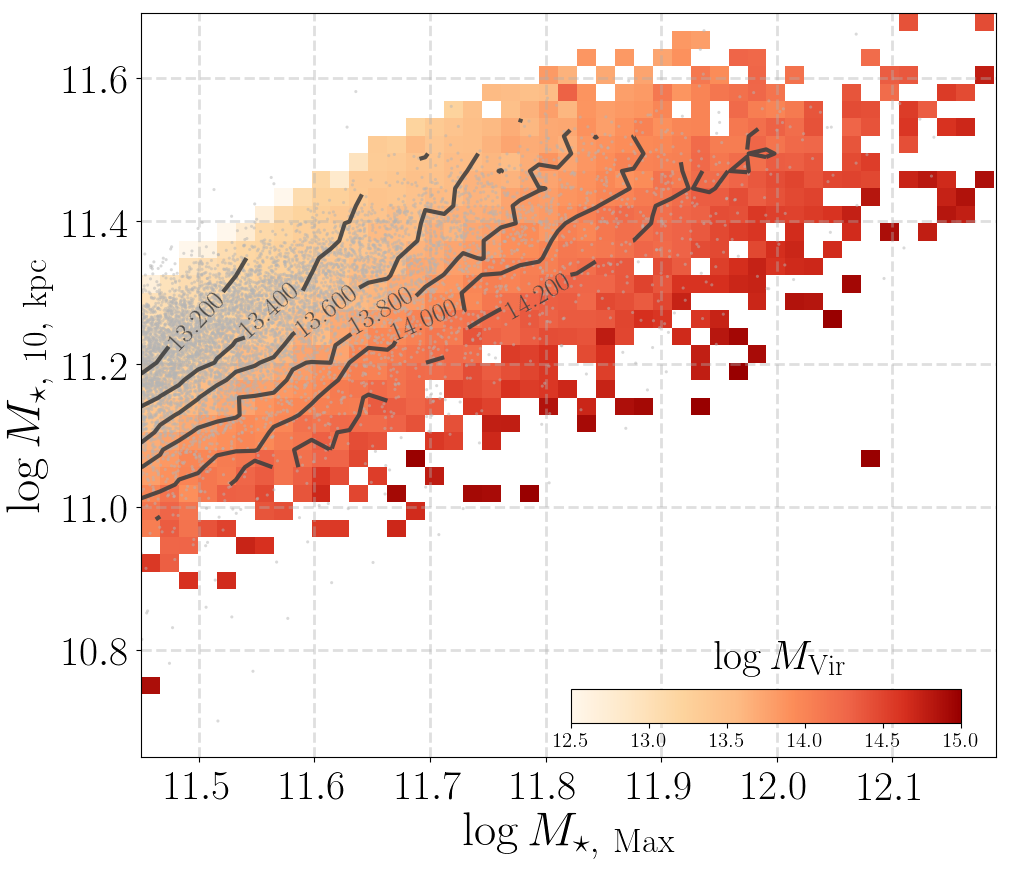

In [90]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot

x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod] + 0.02
z_arr = um_more['logmh_peak'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.00,
                aspect='auto', interpolation='nearest',
                cmap=ORG)

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmean, bins=(45, 40))
CT = ax1.contour(x_edges[:-1], y_edges[:-1],
                 gaussian_filter(z_stats.T, 0.18),
                 7, linewidths=3.0, fontsize=25, alpha=0.9,
                 colors=[BLK(0.8), BLK(0.8), BLK(0.8), BLK(0.8), BLK(0.8), BLK(0.8)],
                 levels=[13.2, 13.4, 13.6, 13.8, 14.0, 14.2],
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=20)

x_arr = mass_use['logm_max']
y_arr = mass_use['logm_10']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.5, facecolor=BLK(0.4), 
            edgecolor='none')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.67, 0.11, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.65, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

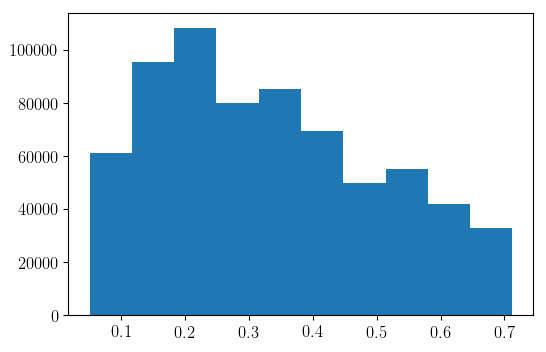

In [112]:
def scale_factor_to_z(scale_factor):
    return (1.0 - scale_factor) / scale_factor

a_50 = um_more[np.isfinite(um_more['a_50'])]['a_50']
#_ = plt.hist(scale_factor_to_z(a_50))

a_lmm = um_more[np.isfinite(um_more['a_lmm'])]['a_lmm']
_ = plt.hist(a_lmm)

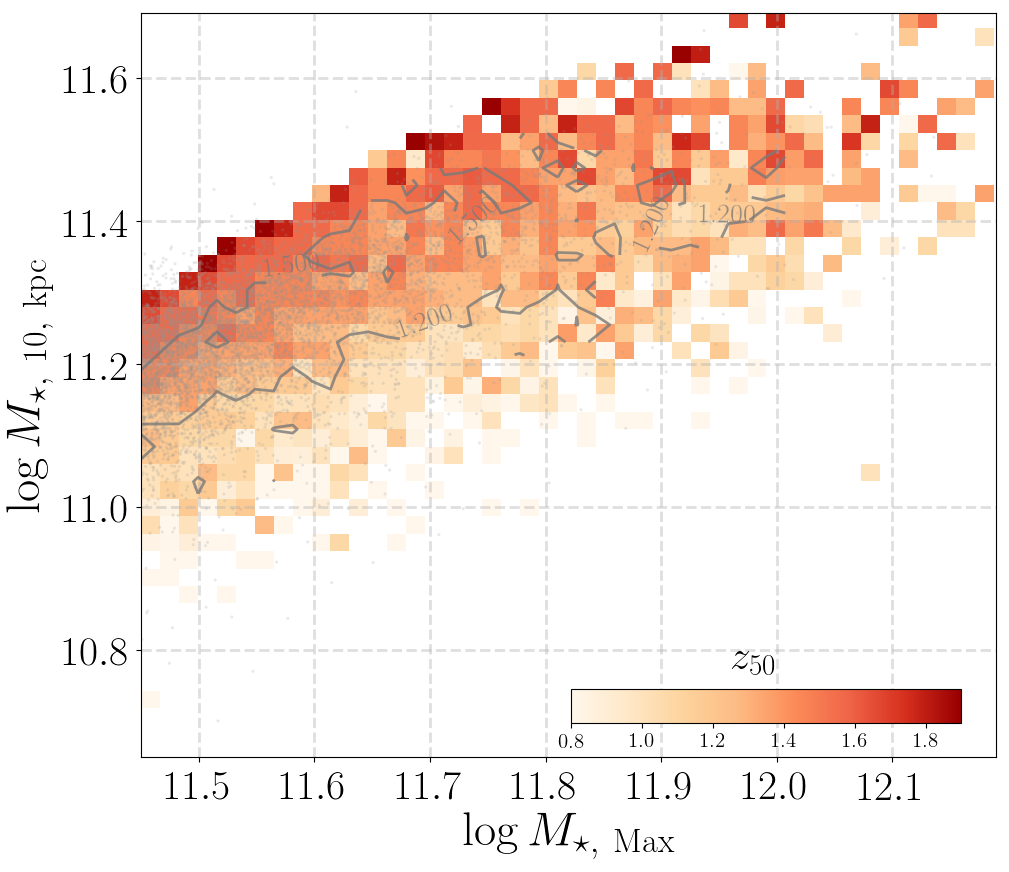

In [109]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot
a50_mask = np.isfinite(um_more['a_50'])
x_arr = logms_mod_tot[mask_mod & a50_mask]
y_arr = logms_mod_inn[mask_mod & a50_mask]
z_arr = scale_factor_to_z(um_more['a_50'][mask_mod & a50_mask])

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=0.80, vmax=1.90,
                aspect='auto', interpolation='nearest',
                cmap=ORG)

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))
CT = ax1.contour(x_edges[:-1], y_edges[:-1],
                 gaussian_filter(z_stats.T, 0.2),
                 2, linewidths=2.0, fontsize=25, alpha=0.8,
                 colors=[BLK(0.6), BLK(0.6), BLK(0.8), BLK(0.8)],
                 levels=[1.2, 1.5],
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=20)

x_arr = mass_use['logm_max']
y_arr = mass_use['logm_10']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.2, facecolor=BLK(0.5), 
            edgecolor='none')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.69, 0.11, r'$z_{50}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.65, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

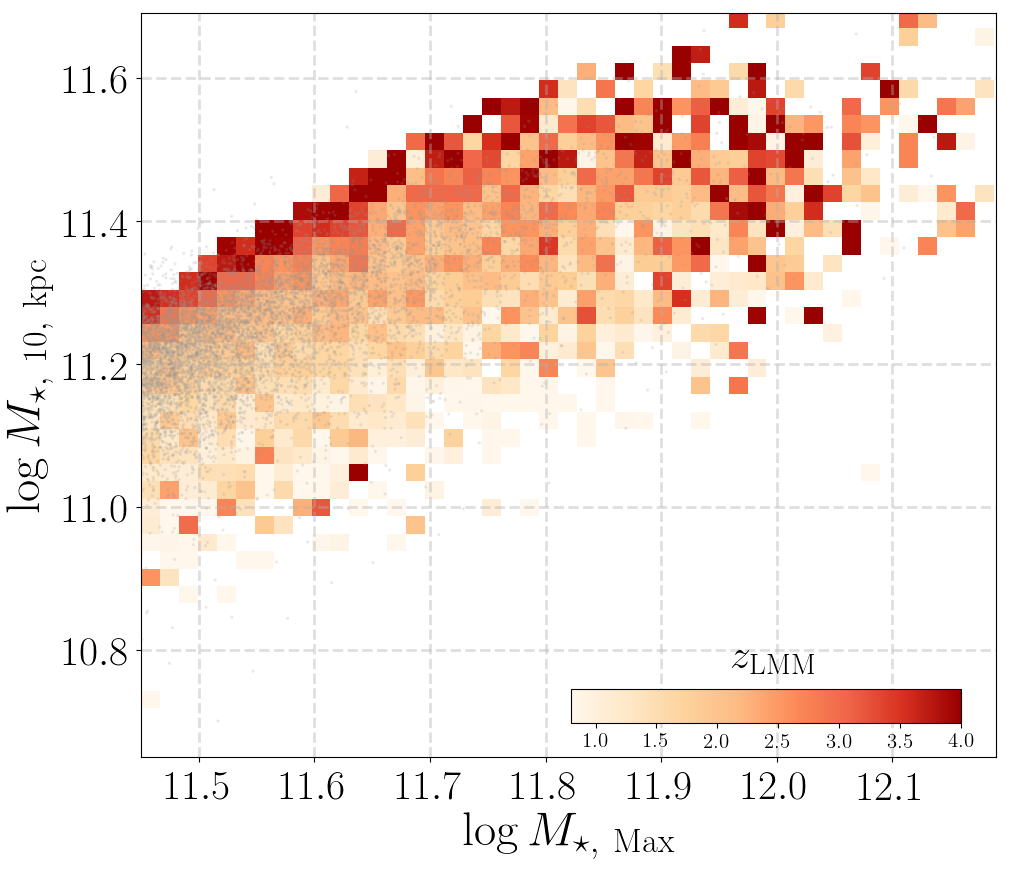

In [119]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot
alm_mask = np.isfinite(um_more['a_lmm'])
x_arr = logms_mod_tot[mask_mod & alm_mask]
y_arr = logms_mod_inn[mask_mod & alm_mask]
z_arr = scale_factor_to_z(um_more['a_lmm'][mask_mod & alm_mask])

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=0.80, vmax=4.00,
                aspect='auto', interpolation='nearest',
                cmap=ORG)

#z_stats, x_edges, y_edges = binned_statistic_2d(
#    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))
#CT = ax1.contour(x_edges[:-1], y_edges[:-1],
#                 gaussian_filter(z_stats.T, 0.2),
#                 2, linewidths=2.0, fontsize=25, alpha=0.8,
#                 colors=[BLK(0.6), BLK(0.6), BLK(0.8), BLK(0.8)],
#                 levels=[1.5, 2.0],
#                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=20)

x_arr = mass_use['logm_max']
y_arr = mass_use['logm_10']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.2, facecolor=BLK(0.5), 
            edgecolor='none')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.69, 0.11, r'$z_{\rm LMM}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.65, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

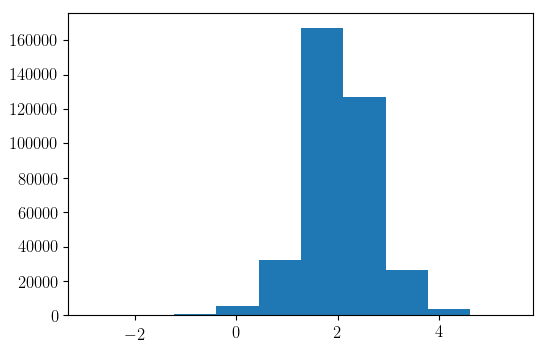

In [135]:
_ = plt.hist(np.log10(um_more[um_more['acc_1dyn'] > 0.0]['acc_1dyn']))

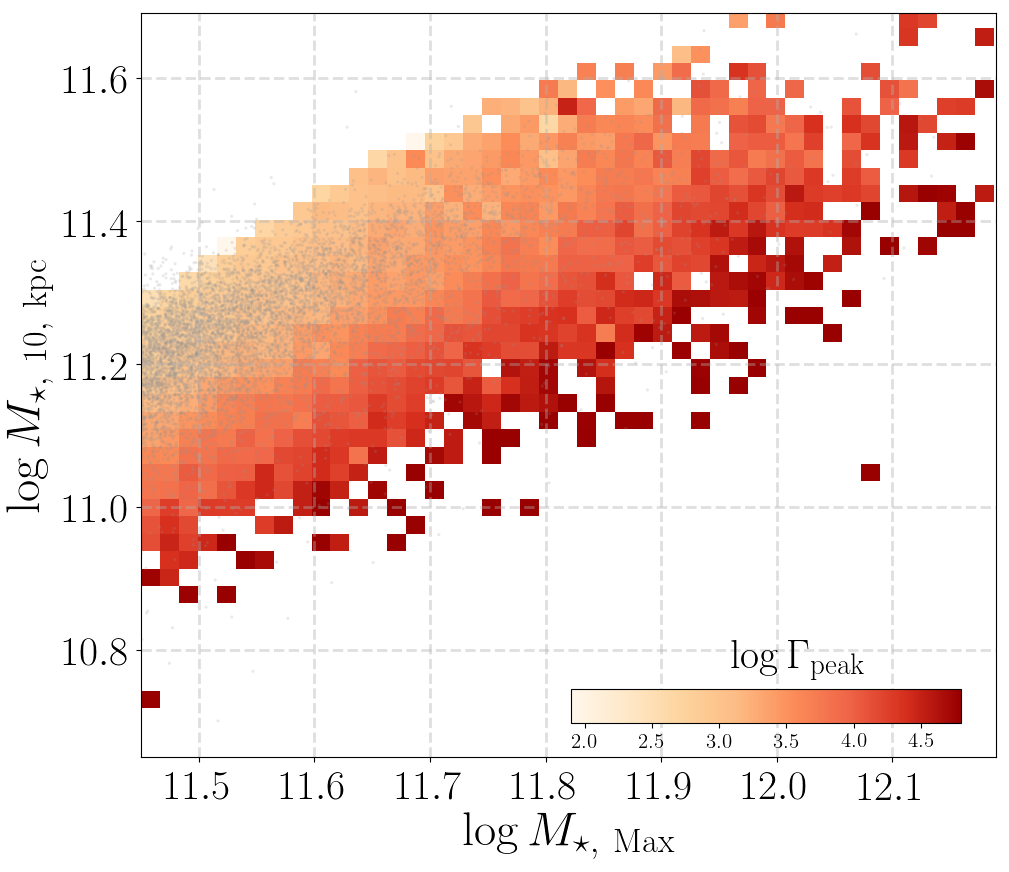

In [134]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot
acc_mask = (um_more['acc_peak'] > 0.0)
x_arr = logms_mod_tot[mask_mod & acc_mask]
y_arr = logms_mod_inn[mask_mod & acc_mask]
z_arr = np.log10(um_more['acc_peak'][mask_mod & acc_mask])

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=1.90, vmax=4.80,
                aspect='auto', interpolation='nearest',
                cmap=ORG)

#z_stats, x_edges, y_edges = binned_statistic_2d(
#    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))
#CT = ax1.contour(x_edges[:-1], y_edges[:-1],
#                 gaussian_filter(z_stats.T, 0.2),
#                 2, linewidths=2.0, fontsize=25, alpha=0.8,
#                 colors=[BLK(0.6), BLK(0.6), BLK(0.8), BLK(0.8)],
#                 levels=[1.5, 2.0],
#                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=20)

x_arr = mass_use['logm_max']
y_arr = mass_use['logm_10']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.2, facecolor=BLK(0.5), 
            edgecolor='none')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.69, 0.11, r'$\log \Gamma_{\rm peak}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.65, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

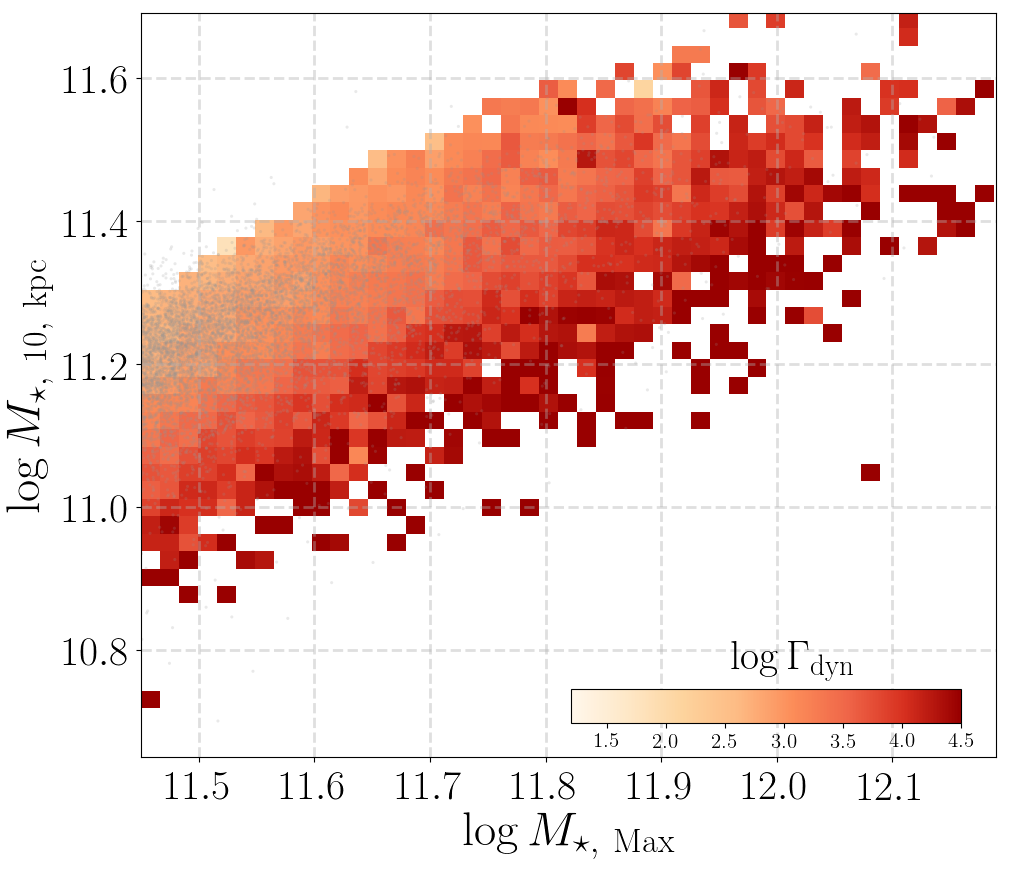

In [138]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot
dyn_mask = (um_more['acc_1dyn'] > 0.0)
x_arr = logms_mod_tot[mask_mod & dyn_mask]
y_arr = logms_mod_inn[mask_mod & dyn_mask]
z_arr = np.log10(um_more['acc_1dyn'][mask_mod & dyn_mask])

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=1.20, vmax=4.50,
                aspect='auto', interpolation='nearest',
                cmap=ORG)

#z_stats, x_edges, y_edges = binned_statistic_2d(
#    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))
#CT = ax1.contour(x_edges[:-1], y_edges[:-1],
#                 gaussian_filter(z_stats.T, 0.2),
#                 2, linewidths=2.0, fontsize=25, alpha=0.8,
#                 colors=[BLK(0.6), BLK(0.6), BLK(0.8), BLK(0.8)],
#                 levels=[1.5, 2.0],
#                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=20)

x_arr = mass_use['logm_max']
y_arr = mass_use['logm_10']
ax1.scatter(x_arr, y_arr, s=5, alpha=0.2, facecolor=BLK(0.5), 
            edgecolor='none')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.69, 0.11, r'$\log \Gamma_{\rm dyn}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.65, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

### PonosV test

* At z~0.38:
    - PonosV : Mvir = 1.04e13 Msol
    - PonosQ : Mvir = 5.90e+12 Msol

In [148]:
ponosv_mask = ((um_mock['logmh_vir'] >= np.log10(1.03E13)) & 
               (um_mock['logmh_vir'] <= np.log10(1.05E13)) &
               (um_mock['upid'] == -1))

print(ponosv_mask.sum())

print(np.nanmedian(logms_mod_tot[ponosv_mask]), 
      np.nanmedian(logms_mod_inn[ponosv_mask]))

795
(11.29465728150313, 11.065098173457843)


Text(9.6,190,'$1.03\\times 10^{13} < M_{\\rm vir} < 1.05\\times 10^{13}$')

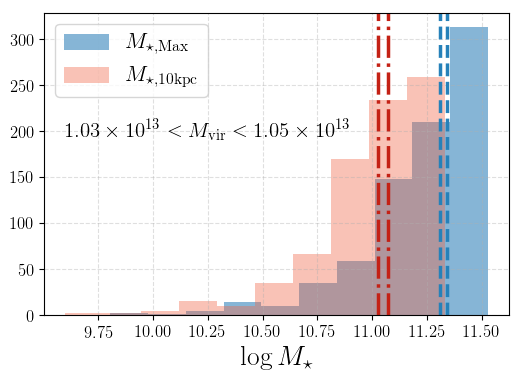

In [193]:
plt.grid(alpha=0.4, linestyle='--', zorder=0)

_ = plt.hist(logms_mod_tot[ponosv_mask], alpha=0.8, label=r'$M_{\star, \rm Max}$', color=BLU(0.7))
_ = plt.hist(logms_mod_inn[ponosv_mask], alpha=0.4, label=r'$M_{\star, \rm 10 kpc}$', color=ORG(0.7))
             
plt.legend(loc='upper left', fontsize=16)

plt.axvline(11.31, linewidth=2.5, linestyle='--', c=BLU(0.9))
plt.axvline(11.34, linewidth=2.5, linestyle='--', c=BLU(0.9))

plt.axvline(11.025, linewidth=2.5, linestyle='-.', c=ORG(0.9))
plt.axvline(11.07, linewidth=2.5, linestyle='-.', c=ORG(0.9))

plt.xlabel(r'$\log M_{\star}$', fontsize=20)

plt.text(9.6, 190, r'$1.03\times 10^{13} < M_{\rm vir} < 1.05\times 10^{13}$', fontsize=15)

In [191]:
msmod_mask = ((logms_mod_tot >= 11.31) & (logms_mod_tot <= 11.34) &
              (logms_mod_inn >= 11.025) & (logms_mod_inn <= 11.07))

print(msmod_mask.sum(), np.nanmedian(um_mock[msmod_mask]['logmh_vir']))

(849, 13.010299956639813)


In [194]:
ponosv_ms_mask = ((mass_use['logm_max'] >= 11.31) &
                  (mass_use['logm_max'] <= 11.34) &
                  (mass_use['logm_10'] >= 11.025) &
                  (mass_use['logm_10'] <= 11.07) &
                  (mass_use['z_best'] >= 0.30) &
                  (mass_use['z_best'] <= 0.40))

print(ponosv_ms_mask.sum())

113


Text(11.58,10.5,'$\\log M_{\\rm Vir,\\ UM}\\sim 13.01$')

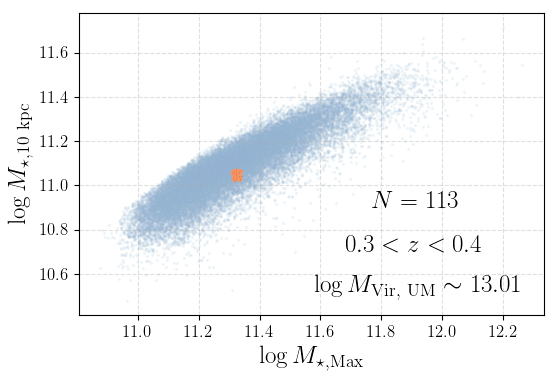

In [209]:
plt.grid(alpha=0.4, linestyle='--', zorder=0)

plt.scatter(mass_use['logm_max'], mass_use['logm_10'], s=2, alpha=0.1,
            facecolor=BLU(0.7), edgecolor=BLU(0.4))

plt.scatter(mass_use['logm_max'][ponosv_ms_mask], 
            mass_use['logm_10'][ponosv_ms_mask], s=2, alpha=0.6,
            facecolor=ORG(0.9), edgecolor=ORG(0.5))

plt.xlabel(r'$\log M_{\star, \rm Max}$', fontsize=18)
plt.ylabel(r'$\log M_{\star, \rm 10\ kpc}$', fontsize=18)

plt.text(11.77, 10.90, r'$N=\mathrm{113}$', fontsize=18)
plt.text(11.68, 10.70, r'$0.3 < z < 0.4$', fontsize=18)
plt.text(11.58, 10.50, r'$\log M_{\rm Vir,\ UM}\sim 13.01$', fontsize=18)

In [212]:
ponosv_hsc = mass_use[ponosv_ms_mask]

ponosv_sbp = ponosv_hsc['sbp']

ponosv_prof = np.nanmedian(ponosv_sbp, axis=0)

Text(1.85,9.2,'$\\mathrm{PonosV-like\\ Galaxies}$')

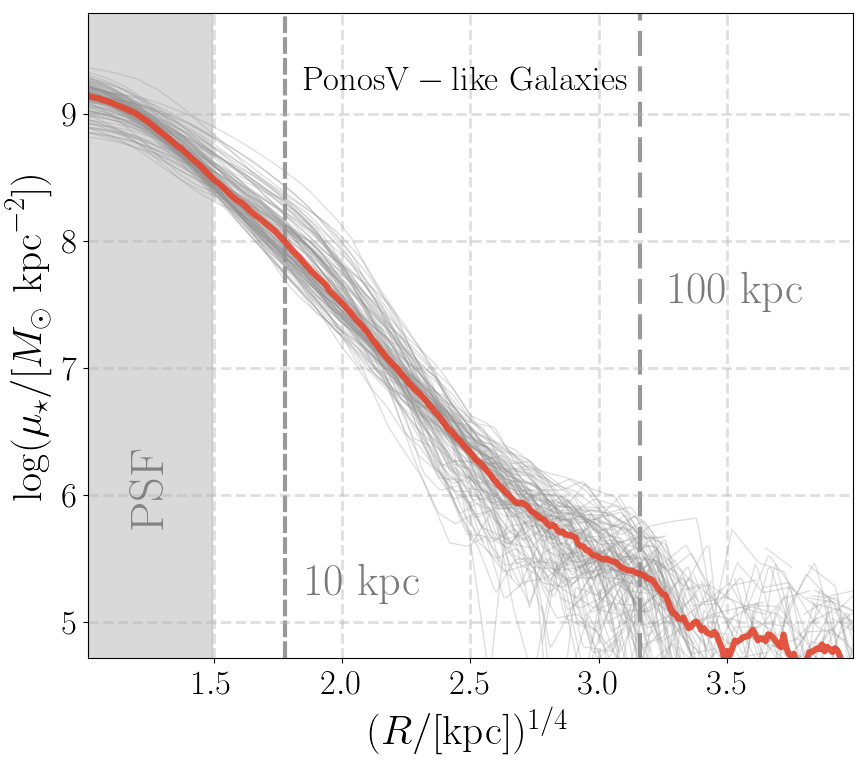

In [220]:
xmin, xmax = 1.01, 3.99
ymin, ymax = 4.71, 9.79
vline1, vline2 = 10.0, 100.0
psf_kpc = 5.0

fig = plt.figure(figsize=(9, 7.5))
fig.subplots_adjust(left=0.14, right=0.99,
                    bottom=0.13, top=0.99,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linewidth=2.0, alpha=0.4, linestyle='--')

y_sep = (ymax - ymin) / 5.0
ax1.fill_between([0.0, psf_kpc ** 0.25], 
                 [ymin - y_sep, ymin - y_sep], 
                 [ymax + y_sep, ymax + y_sep], 
                 facecolor='k', edgecolor='k', alpha=0.15, zorder=0)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=35.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

ax1.axvline(vline1 ** 0.25, linewidth=3.0, c='k', linestyle='--', 
            zorder=0, alpha=0.4, dashes=(4, 1))
ax1.axvline(vline2 ** 0.25, linewidth=3.0, c='k', linestyle='--', 
            zorder=0, alpha=0.4, dashes=(6, 2.5))

ax1.text(12.0 ** 0.25, 5.2, r'$\mathrm{10\ kpc}$', fontsize=32, 
         color=BLK(0.6))
ax1.text(115.0 ** 0.25, 7.5, r'$\mathrm{100\ kpc}$', fontsize=32,
         color=BLK(0.6))

for prof in ponosv_sbp:
    ax1.plot(RSMA_COMMON, prof, linewidth=1.0, alpha=0.3, c=BLK(0.5))

ax1.plot(RSMA_COMMON, ponosv_prof, c=ORG(0.8), linewidth=4.5, alpha=0.9)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
_ = ax1.set_xlim(xmin, xmax)
_ = ax1.set_ylim(ymin, ymax)

_ = ax1.set_xlabel('$(R/[\mathrm{kpc}])^{1/4}$', size=30)
_ = ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$', size=30)

ax1.text(1.85, 9.2, r'$\mathrm{PonosV-like\ Galaxies}$', fontsize=25)

#fig.savefig('fig/s16a_massive_mmax_m10_split_mprof.pdf', dpi=120)

In [221]:
np.savez('/Users/song/Dropbox/work/temp/ponosv_hsc_profiles.npz', 
         profs=ponosv_sbp, avg=ponosv_prof)

### Galaxy-galaxy lensing signals at different halo mass

In [617]:
mh_bin_1 = (um_more['logmh_vir'] >= 13.2) & (um_more['logmh_vir'] < 13.3) & (um_more['upid'] == -1)
mh_bin_2 = (um_more['logmh_vir'] >= 13.3) & (um_more['logmh_vir'] < 13.4) & (um_more['upid'] == -1)
mh_bin_3 = (um_more['logmh_vir'] >= 13.4) & (um_more['logmh_vir'] < 13.5) & (um_more['upid'] == -1)
mh_bin_4 = (um_more['logmh_vir'] >= 13.5) & (um_more['logmh_vir'] < 13.6) & (um_more['upid'] == -1)
mh_bin_5 = (um_more['logmh_vir'] >= 13.6) & (um_more['logmh_vir'] < 13.7) & (um_more['upid'] == -1)
mh_bin_6 = (um_more['logmh_vir'] >= 13.7) & (um_more['logmh_vir'] < 13.8) & (um_more['upid'] == -1)
mh_bin_7 = (um_more['logmh_vir'] >= 13.8) & (um_more['logmh_vir'] < 13.9) & (um_more['upid'] == -1)
mh_bin_8 = (um_more['logmh_vir'] >= 13.9) & (um_more['logmh_vir'] < 14.0) & (um_more['upid'] == -1)
mh_bin_9 = (um_more['logmh_vir'] >= 14.0) & (um_more['logmh_vir'] < 14.1) & (um_more['upid'] == -1)
mh_bin_10 = (um_more['logmh_vir'] >= 14.1) & (um_more['logmh_vir'] < 14.2) & (um_more['upid'] == -1)
mh_bin_11 = (um_more['logmh_vir'] >= 14.2) & (um_more['logmh_vir'] < 14.3) & (um_more['upid'] == -1)
mh_bin_12 = (um_more['logmh_vir'] >= 14.3) & (um_more['logmh_vir'] < 14.5) & (um_more['upid'] == -1)

In [619]:
um_rp_phy = np.logspace(np.log10(0.01), np.log10(40.0), 22)

mh_dsig_1 = asap_um_dsigma(cfg_use, um_more[mh_bin_1], um_dsig[mh_bin_1, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_2 = asap_um_dsigma(cfg_use, um_more[mh_bin_2], um_dsig[mh_bin_2, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_3 = asap_um_dsigma(cfg_use, um_more[mh_bin_3], um_dsig[mh_bin_3, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_4 = asap_um_dsigma(cfg_use, um_more[mh_bin_4], um_dsig[mh_bin_4, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_5 = asap_um_dsigma(cfg_use, um_more[mh_bin_5], um_dsig[mh_bin_5, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_6 = asap_um_dsigma(cfg_use, um_more[mh_bin_6], um_dsig[mh_bin_6, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_7 = asap_um_dsigma(cfg_use, um_more[mh_bin_7], um_dsig[mh_bin_7, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_8 = asap_um_dsigma(cfg_use, um_more[mh_bin_8], um_dsig[mh_bin_8, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_9 = asap_um_dsigma(cfg_use, um_more[mh_bin_9], um_dsig[mh_bin_9, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_10 = asap_um_dsigma(cfg_use, um_more[mh_bin_10], um_dsig[mh_bin_10, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_dsig_11 = asap_um_dsigma(cfg_use, um_more[mh_bin_11], um_dsig[mh_bin_11, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

mh_bin_12 = (um_more['logmh_vir'] >= 14.3) & (um_more['logmh_vir'] < 14.5) & (um_more['upid'] == -1)
mh_dsig_12 = asap_um_dsigma(cfg_use, um_more[mh_bin_12], um_dsig[mh_bin_12, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

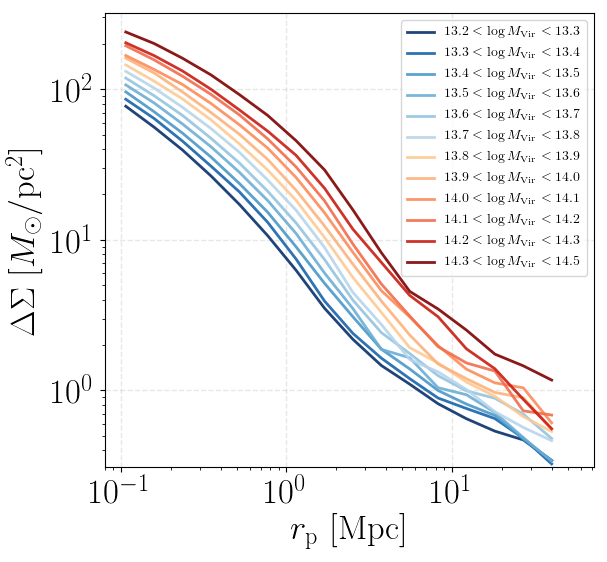

In [644]:
fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax.plot(um_rp_phy, mh_dsig_1,
        linewidth=2.0, color=BLU(1.0), alpha=0.9,
        label=r'$13.2 < \log M_{\rm Vir} < 13.3$')

ax.plot(um_rp_phy, mh_dsig_2,
        linewidth=2.0, color=BLU(0.8), alpha=0.9,
        label=r'$13.3 < \log M_{\rm Vir} < 13.4$')

ax.plot(um_rp_phy, mh_dsig_3,
        linewidth=2.0, color=BLU(0.6), alpha=0.9,
        label=r'$13.4 < \log M_{\rm Vir} < 13.5$')

ax.plot(um_rp_phy, mh_dsig_4,
        linewidth=2.0, color=BLU(0.5), alpha=0.9,
        label=r'$13.5 < \log M_{\rm Vir} < 13.6$')

ax.plot(um_rp_phy, mh_dsig_5,
        linewidth=2.0, color=BLU(0.4), alpha=0.9,
        label=r'$13.6 < \log M_{\rm Vir} < 13.7$')

ax.plot(um_rp_phy, mh_dsig_6,
        linewidth=2.0, color=BLU(0.3), alpha=0.9,
        label=r'$13.7 < \log M_{\rm Vir} < 13.8$')

ax.plot(um_rp_phy, mh_dsig_7,
        linewidth=2.0, color=ORG(0.3), alpha=0.9,
        label=r'$13.8 < \log M_{\rm Vir} < 13.9$')

ax.plot(um_rp_phy, mh_dsig_8,
        linewidth=2.0, color=ORG(0.4), alpha=0.9,
        label=r'$13.9 < \log M_{\rm Vir} < 14.0$')

ax.plot(um_rp_phy, mh_dsig_9,
        linewidth=2.0, color=ORG(0.5), alpha=0.9,
        label=r'$14.0 < \log M_{\rm Vir} < 14.1$')

ax.plot(um_rp_phy, mh_dsig_10,
        linewidth=2.0, color=ORG(0.6), alpha=0.9,
        label=r'$14.1 < \log M_{\rm Vir} < 14.2$')

ax.plot(um_rp_phy, mh_dsig_11,
        linewidth=2.0, color=ORG(0.8), alpha=0.9,
        label=r'$14.2 < \log M_{\rm Vir} < 14.3$')

ax.plot(um_rp_phy, mh_dsig_12,
        linewidth=2.0, color=ORG(1.0), alpha=0.9,
        label=r'$14.3 < \log M_{\rm Vir} < 14.5$')

ax.legend(fontsize=10, loc='upper right')

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.5
y_max = np.nanmax(um_dsig_halo_2) * 1.8

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

_ = ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
_ = ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

In [635]:
halo_temp = um_more[mh_bin_10]
dsig_temp = um_dsig[mh_bin_10, :]

dsig_bin_10_all = [asap_um_dsigma(cfg_use, halo_temp[ii], (dsig_temp[ii, :]).reshape(1, 22), 
                                  mask=None, weight=None, r_interp=um_rp_phy) for ii in np.arange(len(halo_temp))]

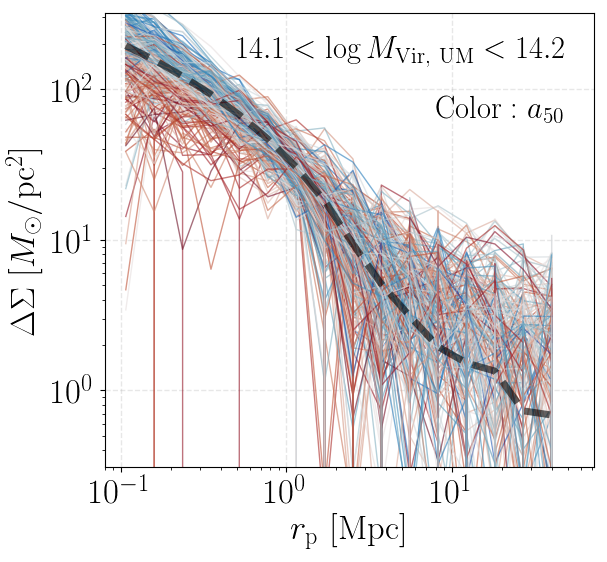

In [660]:
fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
a50_use = (halo_temp['a_50'] - 0.30) / 0.4
    
for jj, prof in enumerate(dsig_bin_10_all):
    ax.plot(um_rp_phy, prof,
            linewidth=1.0, alpha=0.6,
            c=DIV(a50_use[jj]),
            label='__no_label__')

ax.plot(um_rp_phy, mh_dsig_10, linestyle='--',
        linewidth=5.0, color=BLK(1.0), alpha=0.6,
        label=r'$14.1 < \log M_{\rm Vir} < 14.2$')

ax.text(0.5, 150, r'$%4.1f < \log M_{\rm Vir,\ UM} < %4.1f$' % (14.1, 14.2), 
        fontsize=22)

ax.text(8.0, 60, r'$\mathrm{Color:\ }a_{50}$', 
        fontsize=22)

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.5
y_max = np.nanmax(um_dsig_halo_2) * 1.8

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

_ = ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
_ = ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

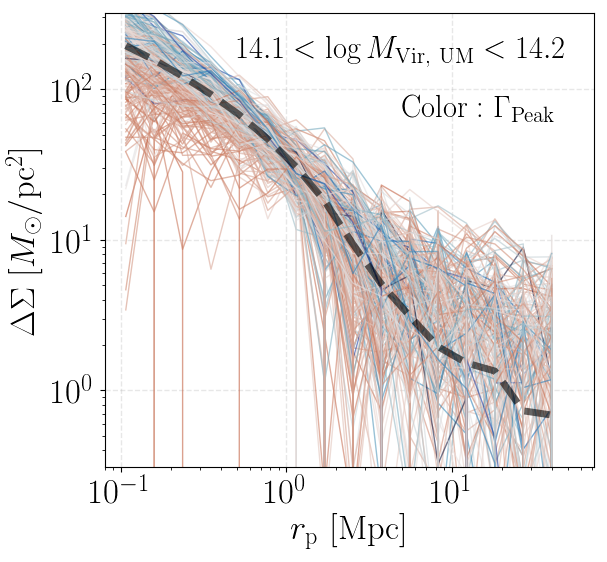

In [667]:
from palettable.cmocean.diverging import Balance_20
DIV = Balance_20.mpl_colormap

fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
acc_use = (np.log10(halo_temp['acc_peak']) - 3.4) / 1.4
    
for jj, prof in enumerate(dsig_bin_10_all):
    ax.plot(um_rp_phy, prof,
            linewidth=1.0, alpha=0.6,
            c=DIV(acc_use[jj]),
            label='__no_label__')

ax.plot(um_rp_phy, mh_dsig_10, linestyle='--',
        linewidth=5.0, color=BLK(1.0), alpha=0.6,
        label=r'$14.1 < \log M_{\rm Vir} < 14.2$')

ax.text(0.5, 150, r'$%4.1f < \log M_{\rm Vir,\ UM} < %4.1f$' % (14.1, 14.2), 
        fontsize=22)

ax.text(5.0, 60, r'$\mathrm{Color:\ }\Gamma_{\rm Peak}$', 
        fontsize=22)

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.5
y_max = np.nanmax(um_dsig_halo_2) * 1.8

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

_ = ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
_ = ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

### First try of assembly bias test

In [601]:
halo_min, halo_max = 14.2, 14.5

halo_mask_1 = (um_more['logmh_vir'] >= halo_min) & (um_more['logmh_vir'] <= halo_max)
cen_mask = um_more['upid'] == -1

print(halo_mask_1.sum(), (halo_mask_1 & cen_mask).sum())

(602, 587)


#### Sliding percentile tests: a_50

(14.305995882770805, 14.304705898212765, 14.298634783124436)
(11.88778288603296, 11.742902791105841, 11.618723797874347)
(11.371799817115397, 11.239075496181123, 11.145889542061804)


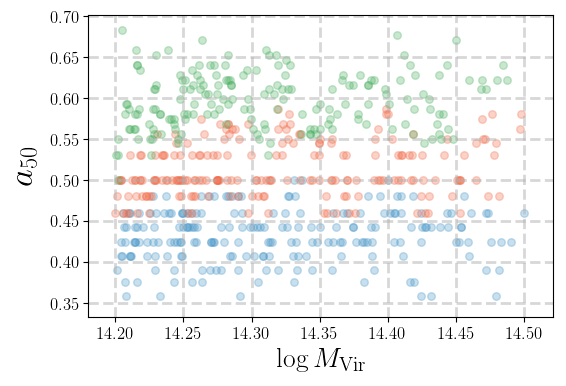

In [614]:
a50_mask_1 = (halo_mask_1 & cen_mask & np.isfinite(um_more['a_50']))

halo_temp = um_more[a50_mask_1]

dsig_temp = um_dsig[a50_mask_1, :]
mtot_temp = logms_mod_tot[a50_mask_1]
minn_temp = logms_mod_inn[a50_mask_1]

halo_temp = Table(halo_temp)
halo_temp.add_column(Column(data=np.arange(len(halo_temp)), name='idx_ori'))

halo_1_a50_split = sample_selection.sampleRankSplit(halo_temp, 
                                                    'logmh_vir', 'a_50',
                                                    n_bins=40, n_sample=3, 
                                                    X_min=halo_min - 0.2, X_max=halo_max + 0.2, 
                                                    id_each_bin=False)
halo_1_a50_split.sort('idx_ori')

a50_bin1 = halo_1_a50_split['sample_id'] == 1
a50_bin2 = halo_1_a50_split['sample_id'] == 2
a50_bin3 = halo_1_a50_split['sample_id'] == 3

print(np.nanmedian(halo_temp['logmh_vir'][a50_bin1]),
      np.nanmedian(halo_temp['logmh_vir'][a50_bin2]),
      np.nanmedian(halo_temp['logmh_vir'][a50_bin3]))

print(np.nanmedian(mtot_temp[a50_bin1]),
      np.nanmedian(mtot_temp[a50_bin2]),
      np.nanmedian(mtot_temp[a50_bin3]))

print(np.nanmedian(minn_temp[a50_bin1]),
      np.nanmedian(minn_temp[a50_bin2]),
      np.nanmedian(minn_temp[a50_bin3]))



plt.scatter(halo_1_a50_split['logmh_vir'][a50_bin1], 
            halo_1_a50_split['a_50'][a50_bin1], 
            s=30, alpha=0.3, c=BLU(0.6))

plt.scatter(halo_1_a50_split['logmh_vir'][a50_bin2], 
            halo_1_a50_split['a_50'][a50_bin2], 
            s=30, alpha=0.3, c=ORG(0.6))

plt.scatter(halo_1_a50_split['logmh_vir'][a50_bin3], 
            halo_1_a50_split['a_50'][a50_bin3], 
            s=30, alpha=0.3, c=GRN(0.6))

_ = plt.grid(linewidth=2.0, linestyle='--', alpha=0.5, zorder=0)
_ = plt.xlabel(r'$\log M_{\rm Vir}$', fontsize=20)
_ = plt.ylabel(r'$a_{\rm 50}$', fontsize=25)

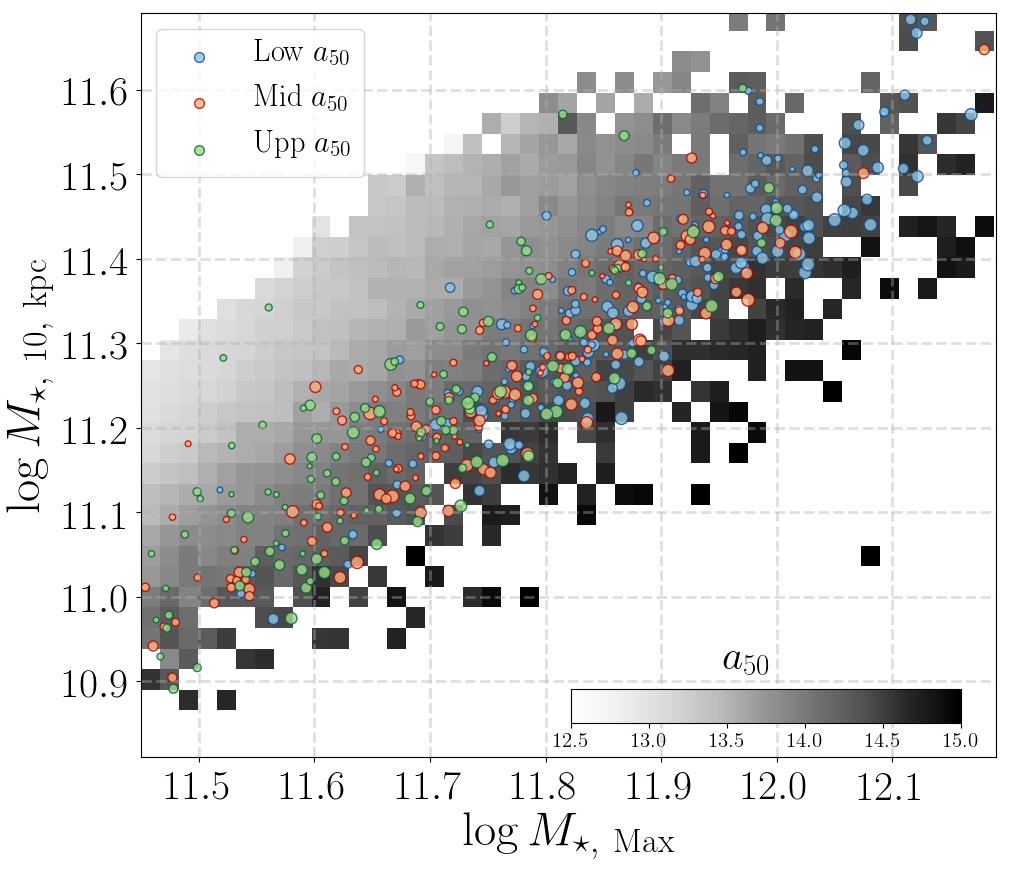

In [603]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot
x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod]
z_arr = um_more['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.00,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

ax1.scatter(mtot_temp[a50_bin1], 
            minn_temp[a50_bin1], 
            s=(halo_temp['logmh_vir'][a50_bin1] - halo_min + 0.05) * 250, 
            alpha=0.8, facecolor=BLU(0.4), edgecolor=BLU(0.9),
            label=r'$\mathrm{Low}\ a_{50}$')

ax1.scatter(mtot_temp[a50_bin2], 
            minn_temp[a50_bin2], 
            s=(halo_temp['logmh_vir'][a50_bin2] - halo_min + 0.05) * 250, 
            alpha=0.8, facecolor=ORG(0.4), edgecolor=ORG(0.9),
            label=r'$\mathrm{Mid}\ a_{50}$')

ax1.scatter(mtot_temp[a50_bin3], 
            minn_temp[a50_bin3], 
            s=(halo_temp['logmh_vir'][a50_bin3] - halo_min + 0.05) * 250, 
            alpha=0.8, facecolor=GRN(0.4), edgecolor=GRN(0.9),
            label=r'$\mathrm{Upp}\ a_{50}$')

ax1.legend(fontsize=22, loc='upper left')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.68, 0.11, r'$a_{50}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

In [604]:
um_rp_phy = np.logspace(np.log10(0.01), np.log10(40.0), 22)

a50_dsig_1 = asap_um_dsigma(cfg_use, halo_temp[a50_bin1], dsig_temp[a50_bin1, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

a50_dsig_2 = asap_um_dsigma(cfg_use, halo_temp[a50_bin2], dsig_temp[a50_bin2, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

a50_dsig_3 = asap_um_dsigma(cfg_use, halo_temp[a50_bin3], dsig_temp[a50_bin3, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

Text(0.5,0,'$r_{\\rm p}$ ${\\rm [Mpc]}$')

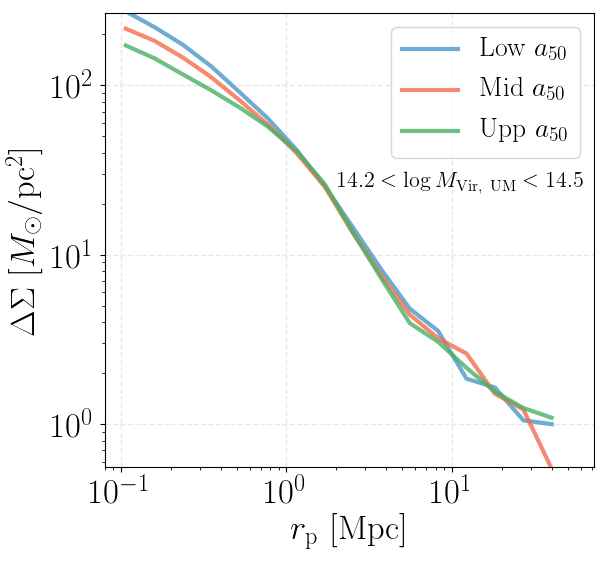

In [605]:
fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax.plot(um_rp_phy, a50_dsig_1,
        linewidth=3.0, color=BLU(0.6), alpha=0.8,
        label=r'$\mathrm{Low}\ a_{50}$')

ax.plot(um_rp_phy, a50_dsig_2,
        linewidth=3.0, color=ORG(0.6), alpha=0.8,
        label=r'$\mathrm{Mid}\ a_{50}$')

ax.plot(um_rp_phy, a50_dsig_3,
        linewidth=3.0, color=GRN(0.6), alpha=0.8,
        label=r'$\mathrm{Upp}\ a_{50}$')

ax.legend(fontsize=20, loc='upper right')

ax.text(2.05, 24.0, r'$%4.1f < \log M_{\rm Vir,\ UM} < %4.1f$' % (halo_min, halo_max), 
        fontsize=16)

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.9
y_max = np.nanmax(um_dsig_halo_2) * 1.5

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

#### Sliding percentile tests: a_lmm

(14.308350948586726, 14.304705898212765, 14.298634783124436)
(11.872278630410568, 11.76443670725642, 11.644601951175773)
(11.370231237653103, 11.240988802709163, 11.166251424912682)


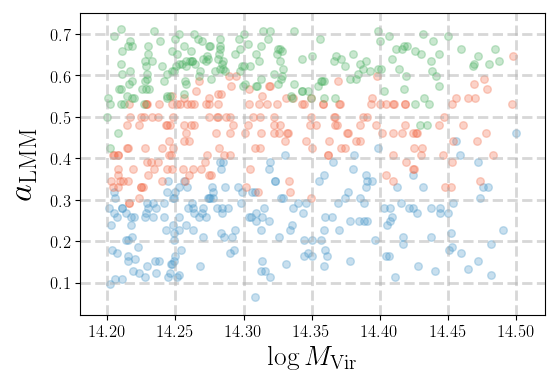

In [615]:
alm_mask_1 = (halo_mask_1 & cen_mask & np.isfinite(um_more['a_lmm']))

halo_temp = um_more[alm_mask_1]
dsig_temp = um_dsig[alm_mask_1, :]
mtot_temp = logms_mod_tot[alm_mask_1]
minn_temp = logms_mod_inn[alm_mask_1]

halo_temp = Table(halo_temp)
halo_temp.add_column(Column(data=np.arange(len(halo_temp)), name='idx_ori'))

halo_1_alm_split = sample_selection.sampleRankSplit(halo_temp, 
                                                    'logmh_vir', 'a_lmm',
                                                    n_bins=40, n_sample=3, 
                                                    X_min=halo_min - 0.2, X_max=halo_max + 0.2, 
                                                    id_each_bin=False)
halo_1_alm_split.sort('idx_ori')

alm_bin1 = halo_1_alm_split['sample_id'] == 1
alm_bin2 = halo_1_alm_split['sample_id'] == 2
alm_bin3 = halo_1_alm_split['sample_id'] == 3

print(np.nanmedian(halo_temp['logmh_vir'][alm_bin1]),
      np.nanmedian(halo_temp['logmh_vir'][alm_bin2]),
      np.nanmedian(halo_temp['logmh_vir'][alm_bin3]))

print(np.nanmedian(mtot_temp[alm_bin1]),
      np.nanmedian(mtot_temp[alm_bin2]),
      np.nanmedian(mtot_temp[alm_bin3]))

print(np.nanmedian(minn_temp[alm_bin1]),
      np.nanmedian(minn_temp[alm_bin2]),
      np.nanmedian(minn_temp[alm_bin3]))



plt.scatter(halo_1_alm_split['logmh_vir'][alm_bin1], 
            halo_1_alm_split['a_lmm'][alm_bin1], 
            s=30, alpha=0.3, c=BLU(0.6))

plt.scatter(halo_1_alm_split['logmh_vir'][alm_bin2], 
            halo_1_alm_split['a_lmm'][alm_bin2], 
            s=30, alpha=0.3, c=ORG(0.6))

plt.scatter(halo_1_alm_split['logmh_vir'][alm_bin3], 
            halo_1_alm_split['a_lmm'][alm_bin3], 
            s=30, alpha=0.3, c=GRN(0.6))

_ = plt.grid(linewidth=2.0, linestyle='--', alpha=0.5, zorder=0)
_ = plt.xlabel(r'$\log M_{\rm Vir}$', fontsize=20)
_ = plt.ylabel(r'$a_{\rm LMM}$', fontsize=25)

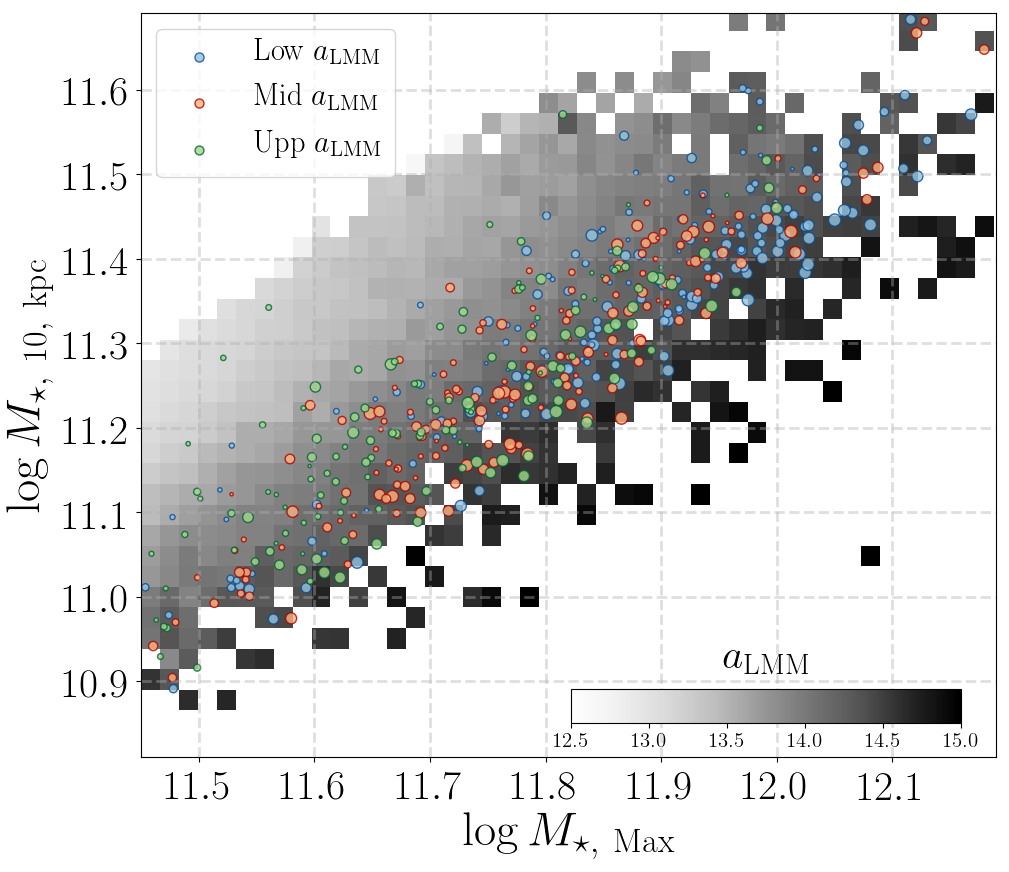

In [607]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot
x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod]
z_arr = um_more['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.00,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

ax1.scatter(mtot_temp[alm_bin1], 
            minn_temp[alm_bin1], 
            s=(halo_temp['logmh_vir'][alm_bin1] - halo_min + 0.02) * 250, 
            alpha=0.8, facecolor=BLU(0.4), edgecolor=BLU(0.9),
            label=r'$\mathrm{Low}\ a_{\rm LMM}$')

ax1.scatter(mtot_temp[alm_bin2], 
            minn_temp[alm_bin2], 
            s=(halo_temp['logmh_vir'][alm_bin2] - halo_min + 0.02) * 250, 
            alpha=0.8, facecolor=ORG(0.4), edgecolor=ORG(0.9),
            label=r'$\mathrm{Mid}\ a_{\rm LMM}$')

ax1.scatter(mtot_temp[alm_bin3], 
            minn_temp[alm_bin3], 
            s=(halo_temp['logmh_vir'][alm_bin3] - halo_min + 0.02) * 250, 
            alpha=0.8, facecolor=GRN(0.4), edgecolor=GRN(0.9),
            label=r'$\mathrm{Upp}\ a_{\rm LMM}$')

ax1.legend(fontsize=22, loc='upper left')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.68, 0.11, r'$a_{\rm LMM}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

In [608]:
um_rp_phy = np.logspace(np.log10(0.01), np.log10(40.0), 22)

alm_dsig_1 = asap_um_dsigma(cfg_use, halo_temp[alm_bin1], dsig_temp[alm_bin1, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

alm_dsig_2 = asap_um_dsigma(cfg_use, halo_temp[alm_bin2], dsig_temp[alm_bin2, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

alm_dsig_3 = asap_um_dsigma(cfg_use, halo_temp[alm_bin3], dsig_temp[alm_bin3, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

Text(0.5,0,'$r_{\\rm p}$ ${\\rm [Mpc]}$')

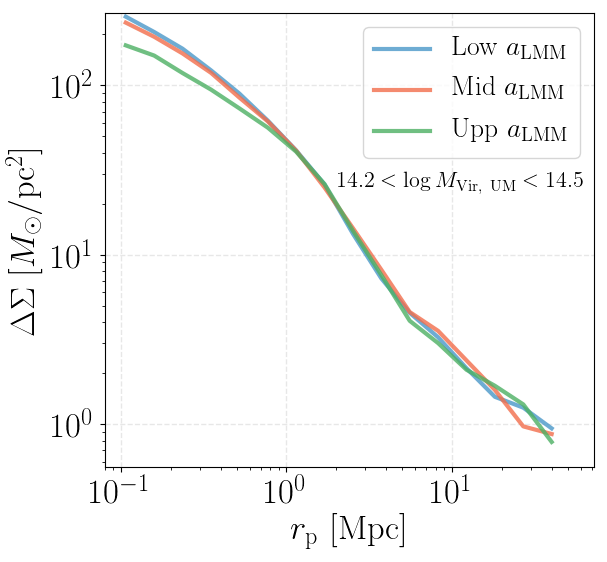

In [609]:
fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax.plot(um_rp_phy, alm_dsig_1,
        linewidth=3.0, color=BLU(0.6), alpha=0.8,
        label=r'$\mathrm{Low}\ a_{\rm LMM}$')

ax.plot(um_rp_phy, alm_dsig_2,
        linewidth=3.0, color=ORG(0.6), alpha=0.8,
        label=r'$\mathrm{Mid}\ a_{\rm LMM}$')

ax.plot(um_rp_phy, alm_dsig_3,
        linewidth=3.0, color=GRN(0.6), alpha=0.8,
        label=r'$\mathrm{Upp}\ a_{\rm LMM}$')

ax.legend(fontsize=20, loc='upper right')

ax.text(2.05, 24.0, r'$%4.1f < \log M_{\rm Vir,\ UM} < %4.1f$' % (halo_min, halo_max), 
        fontsize=16)

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.9
y_max = np.nanmax(um_dsig_halo_2) * 1.5

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

#### Sliding percentile tests: acc_peak

(14.308137378638039, 14.304059466217598, 14.298634783124436)
(11.88778288603296, 11.773573421026136, 11.597731613445271)
(11.370288152685852, 11.251981637158298, 11.118723647011091)


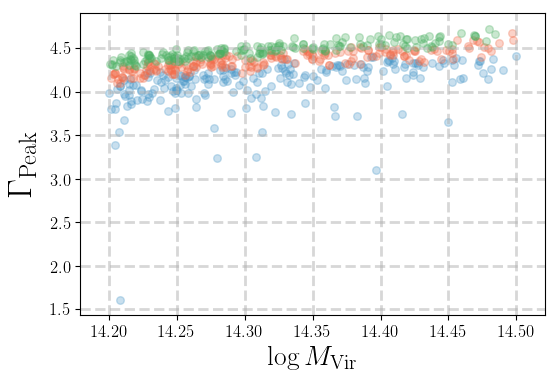

In [616]:
acc_mask_1 = (halo_mask_1 & cen_mask & np.isfinite(um_more['acc_peak']))

halo_temp = um_more[acc_mask_1]
dsig_temp = um_dsig[acc_mask_1, :]
mtot_temp = logms_mod_tot[acc_mask_1]
minn_temp = logms_mod_inn[acc_mask_1]

halo_temp = Table(halo_temp)
halo_temp.add_column(Column(data=np.arange(len(halo_temp)), name='idx_ori'))

halo_1_acc_split = sample_selection.sampleRankSplit(halo_temp, 
                                                    'logmh_vir', 'acc_peak',
                                                    n_bins=40, n_sample=3, 
                                                    X_min=halo_min - 0.2, X_max=halo_max + 0.2, 
                                                    id_each_bin=False)
halo_1_acc_split.sort('idx_ori')

acc_bin1 = halo_1_acc_split['sample_id'] == 1
acc_bin2 = halo_1_acc_split['sample_id'] == 2
acc_bin3 = halo_1_acc_split['sample_id'] == 3

print(np.nanmedian(halo_temp['logmh_vir'][acc_bin1]),
      np.nanmedian(halo_temp['logmh_vir'][acc_bin2]),
      np.nanmedian(halo_temp['logmh_vir'][acc_bin3]))

print(np.nanmedian(mtot_temp[acc_bin1]),
      np.nanmedian(mtot_temp[acc_bin2]),
      np.nanmedian(mtot_temp[acc_bin3]))

print(np.nanmedian(minn_temp[acc_bin1]),
      np.nanmedian(minn_temp[acc_bin2]),
      np.nanmedian(minn_temp[acc_bin3]))


plt.scatter(halo_1_acc_split['logmh_vir'][acc_bin1], 
            np.log10(halo_1_acc_split['acc_peak'][acc_bin1]), 
            s=30, alpha=0.3, c=BLU(0.6))

plt.scatter(halo_1_acc_split['logmh_vir'][acc_bin2], 
            np.log10(halo_1_acc_split['acc_peak'][acc_bin2]), 
            s=30, alpha=0.3, c=ORG(0.6))

plt.scatter(halo_1_acc_split['logmh_vir'][acc_bin3], 
            np.log10(halo_1_acc_split['acc_peak'][acc_bin3]), 
            s=30, alpha=0.3, c=GRN(0.6))

#plt.ylim(3.1, 5.49)

_ = plt.grid(linewidth=2.0, linestyle='--', alpha=0.5, zorder=0)
_ = plt.xlabel(r'$\log M_{\rm Vir}$', fontsize=20)
_ = plt.ylabel(r'$\Gamma_{\rm Peak}$', fontsize=25)

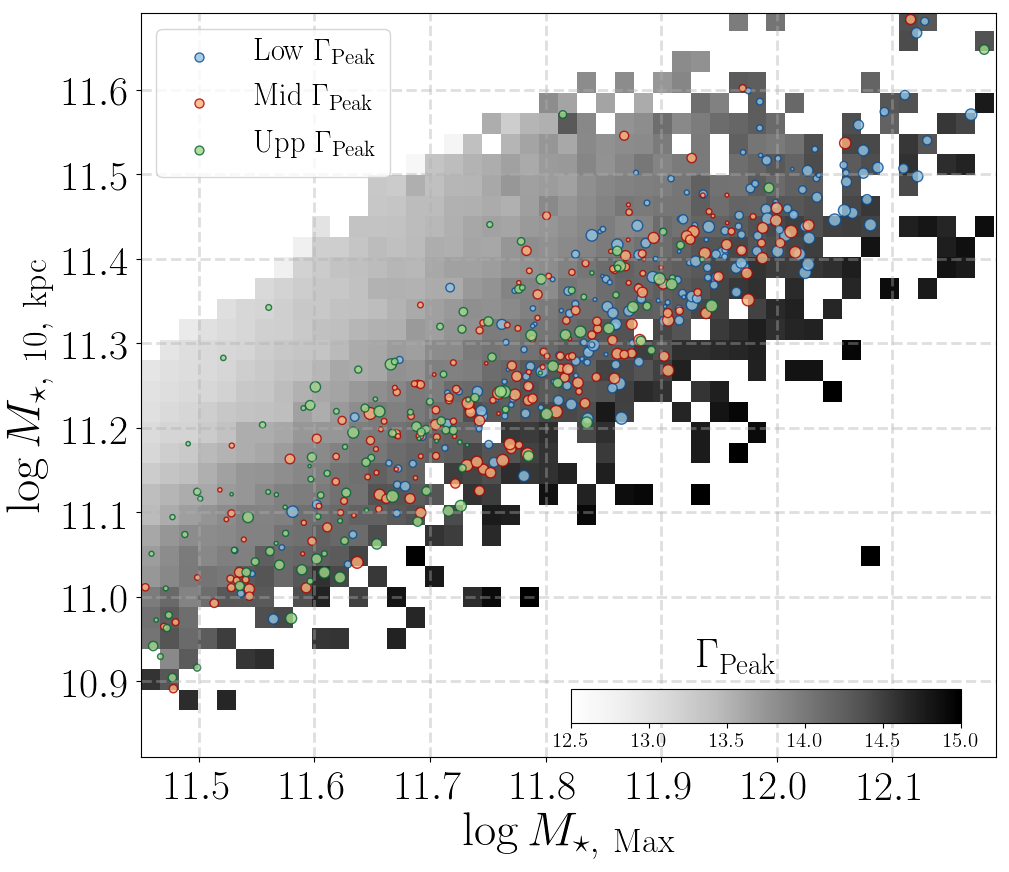

In [611]:
fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot
x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod]
z_arr = um_more['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.00,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

ax1.scatter(mtot_temp[acc_bin1], 
            minn_temp[acc_bin1], 
            s=(halo_temp['logmh_vir'][acc_bin1] - halo_min + 0.02) * 250, 
            alpha=0.8, facecolor=BLU(0.4), edgecolor=BLU(0.9),
            label=r'$\mathrm{Low}\ \Gamma_{\rm Peak}$')

ax1.scatter(mtot_temp[acc_bin2], 
            minn_temp[acc_bin2], 
            s=(halo_temp['logmh_vir'][acc_bin2] - halo_min + 0.02) * 250, 
            alpha=0.8, facecolor=ORG(0.4), edgecolor=ORG(0.9),
            label=r'$\mathrm{Mid}\ \Gamma_{\rm Peak}$')

ax1.scatter(mtot_temp[acc_bin3], 
            minn_temp[acc_bin3], 
            s=(halo_temp['logmh_vir'][acc_bin3] - halo_min + 0.02) * 250, 
            alpha=0.8, facecolor=GRN(0.4), edgecolor=GRN(0.9),
            label=r'$\mathrm{Upp}\ \Gamma_{\rm Peak}$')

ax1.legend(fontsize=22, loc='upper left')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.65, 0.11, r'$\Gamma_{\rm Peak}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

In [612]:
um_rp_phy = np.logspace(np.log10(0.01), np.log10(40.0), 22)

acc_dsig_1 = asap_um_dsigma(cfg_use, halo_temp[acc_bin1], dsig_temp[acc_bin1, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

acc_dsig_2 = asap_um_dsigma(cfg_use, halo_temp[acc_bin2], dsig_temp[acc_bin2, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

acc_dsig_3 = asap_um_dsigma(cfg_use, halo_temp[acc_bin3], dsig_temp[acc_bin3, :], 
                            mask=None, weight=None, r_interp=um_rp_phy)

Text(0.5,0,'$r_{\\rm p}$ ${\\rm [Mpc]}$')

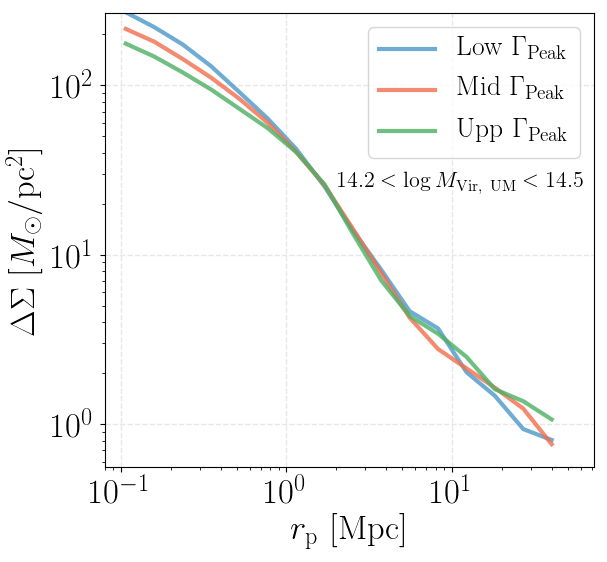

In [613]:
fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax.plot(um_rp_phy, acc_dsig_1,
        linewidth=3.0, color=BLU(0.6), alpha=0.8,
        label=r'$\mathrm{Low}\ \Gamma_{\rm Peak}$')

ax.plot(um_rp_phy, acc_dsig_2,
        linewidth=3.0, color=ORG(0.6), alpha=0.8,
        label=r'$\mathrm{Mid}\ \Gamma_{\rm Peak}$')

ax.plot(um_rp_phy, acc_dsig_3,
        linewidth=3.0, color=GRN(0.6), alpha=0.8,
        label=r'$\mathrm{Upp}\ \Gamma_{\rm Peak}$')

ax.legend(fontsize=20, loc='upper right')

ax.text(2.05, 24.0, r'$%4.1f < \log M_{\rm Vir,\ UM} < %4.1f$' % (halo_min, halo_max), 
        fontsize=16)

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.9
y_max = np.nanmax(um_dsig_halo_2) * 1.5

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

### Random splitting test

(1019, 974)


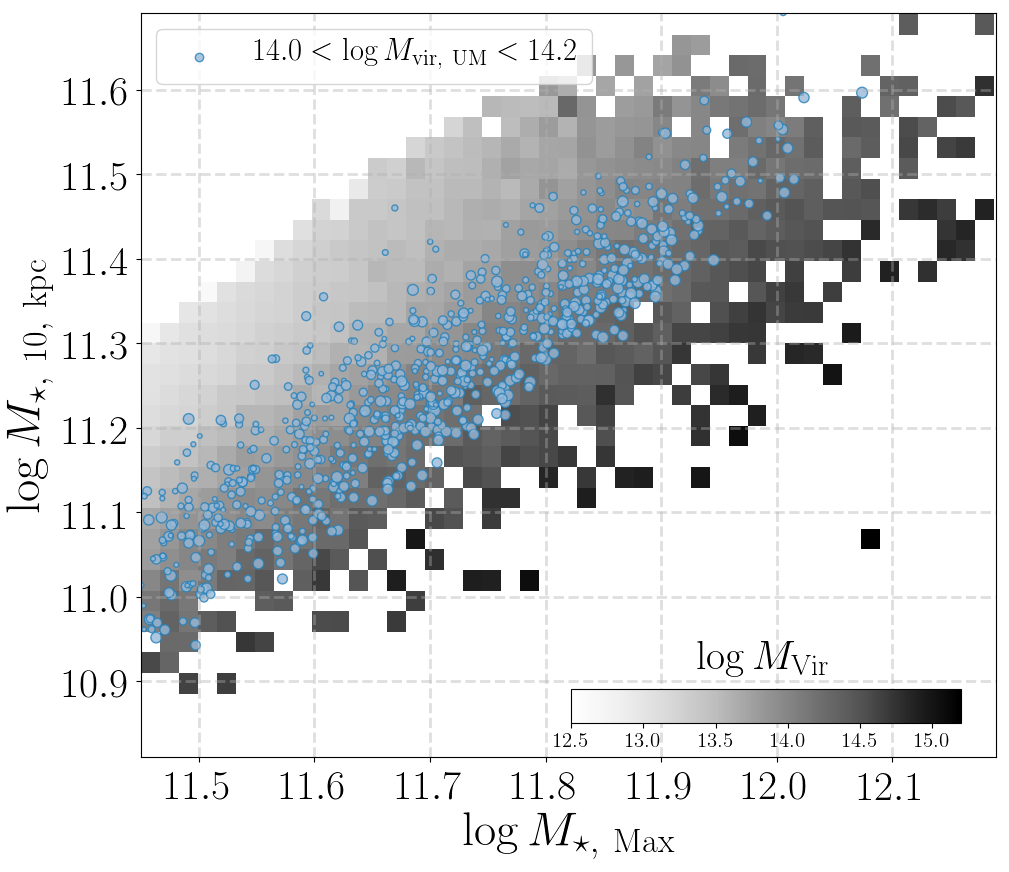

In [290]:
halo_mask_2 = ((um_more['logmh_vir'] >= 14.0) & (um_more['logmh_vir'] <= 14.2))

print(halo_mask_2.sum(), (halo_mask_2 & cen_mask).sum())

fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot

x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod] + 0.02
z_arr = um_more['logmh_peak'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 40))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.20,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

#x_arr = mass_use['logm_max']
#y_arr = mass_use['logm_10']
#ax1.scatter(x_arr, y_arr, s=5, alpha=0.5, facecolor=BLK(0.4), 
#            edgecolor='none')

ax1.scatter(logms_mod_tot[halo_mask_2 & cen_mask], 
            logms_mod_inn[halo_mask_2 & cen_mask], 
            s=(um_more['logmh_vir'][halo_mask_2 & cen_mask] - 13.96) * 260, 
            alpha=0.8, facecolor=BLU(0.5), edgecolor=BLU(0.9),
            label=r'$14.0 < \log M_{\rm vir,\ UM} < 14.2$')

ax1.legend(fontsize=22, loc='upper left')

## Colorbar
cax = fig.add_axes([0.57, 0.16, 0.39, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.65, 0.11, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

(13.965107585849056, 13.869994000121741)
(0.424, 0.46)
(0.318, 0.39)
(6140.0, 6098.5)
(3788.5, 3329.0)
(4062.0, 3974.0)


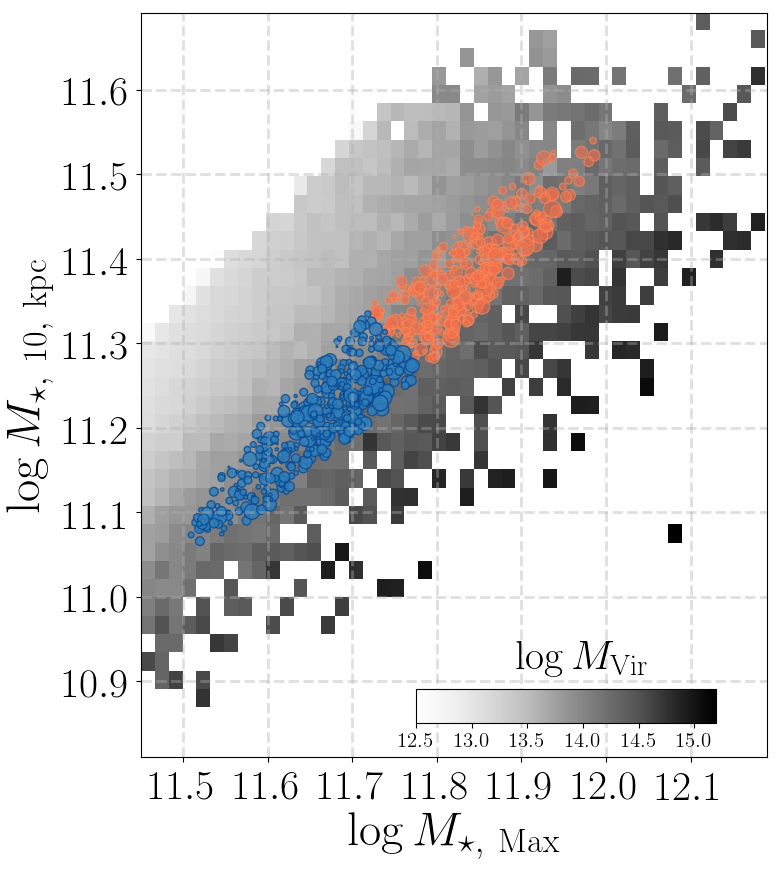

In [824]:
#um_group = um_more[halo_mask_2]
#um_dsig_group = um_dsig[halo_mask_2, :]

um_group = um_more
um_dsig_group = um_dsig

#x_arr, y_arr = logms_mod_tot[halo_mask_2], logms_mod_inn[halo_mask_2]
#x_cen, y_cen = np.median(logms_mod_tot[halo_mask_2]), np.median(logms_mod_inn[halo_mask_2])
x_arr, y_arr = logms_mod_tot, logms_mod_inn

#x_cen, y_cen = 11.82, 11.37
#x_cen, y_cen = 11.75, 11.32
x_cen = 11.75
y_cen = 1.00 * x_cen - 0.44627

pa, ba = 135, 0.02
nsample = 2000

group1_mask, group2_mask = ellipse_split_2d(x_arr, y_arr, x_cen, y_cen, 
                                            pa, ba, nsample=nsample)

print(np.nanmedian(um_group[group1_mask]['logmh_vir']),
      np.nanmedian(um_group[group2_mask]['logmh_vir']))

print(np.nanmedian(um_group[group1_mask]['a_50']),
      np.nanmedian(um_group[group2_mask]['a_50']))

print(np.nanmedian(um_group[group1_mask]['a_lmm']),
      np.nanmedian(um_group[group2_mask]['a_lmm']))

print(np.nanmedian(um_group[group1_mask]['acc_peak']),
      np.nanmedian(um_group[group2_mask]['acc_peak']))

print(np.nanmedian(um_group[group1_mask]['acc_now']),
      np.nanmedian(um_group[group2_mask]['acc_now']))

print(np.nanmedian(um_group[group1_mask]['acc_1dyn']),
      np.nanmedian(um_group[group2_mask]['acc_1dyn']))


fig = plt.figure(figsize=(10, 8.5))

fig.subplots_adjust(left=0.14, right=0.995,
                    bottom=0.12, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

## M100-M10 scatter plot

xx = logms_mod_tot[mask_mod]
yy = logms_mod_inn[mask_mod] + 0.02
zz = um_more['logmh_peak'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    xx, yy, zz, np.nanmedian, bins=(45, 45))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.20,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

ax1.scatter(x_arr[group1_mask], 
            y_arr[group1_mask], 
            s=(um_group['logmh_vir'][group1_mask] - 13.96) * 260, 
            alpha=0.6, facecolor=ORG(0.6), edgecolor=ORG(0.5),
            label=r'$\mathrm{Group\ 1}$')

ax1.scatter(x_arr[group2_mask], 
            y_arr[group2_mask], 
            s=(um_group['logmh_vir'][group2_mask] - 13.96) * 250, 
            alpha=0.8, facecolor=BLU(0.7), edgecolor=BLU(0.9),
            label=r'$\mathrm{Group\ 2}$')

#ax1.legend(fontsize=22, loc='upper left')

## Colorbar
cax = fig.add_axes([0.53, 0.16, 0.30, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.60, 0.11, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=30)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)

ax1.set_aspect('equal')

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

Text(0.5,0,'$r_{\\rm p}$ ${\\rm [Mpc]}$')

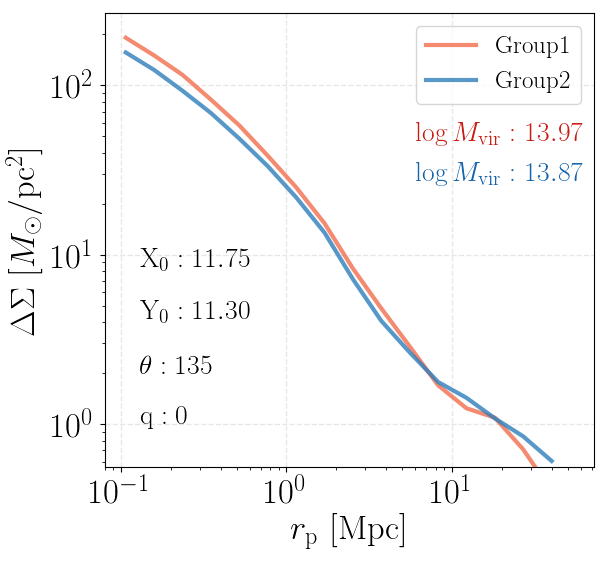

In [825]:
um_dsig_group_a = asap_um_dsigma(cfg_use, um_group[group1_mask & group2_mask], 
                                 um_dsig_group[group1_mask & group2_mask, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)

um_dsig_group_1 = asap_um_dsigma(cfg_use, um_group[group1_mask], um_dsig_group[group1_mask, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)

um_dsig_group_2 = asap_um_dsigma(cfg_use, um_group[group2_mask], um_dsig_group[group2_mask, :], 
                                 mask=None, weight=None, r_interp=um_rp_phy)

fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax.plot(um_rp_phy, um_dsig_group_1,
        linewidth=3.0, color=ORG(0.6), alpha=0.8,
        label=r'$\mathrm{Group1}$')

ax.plot(um_rp_phy, um_dsig_group_2,
        linewidth=3.0, color=BLU(0.7), alpha=0.8,
        label=r'$\mathrm{Group2}$')

ax.legend(fontsize=18, loc='upper right')

ax.text(0.13, 8.0, r'$\mathrm{X}_0: %5.2f$' % x_cen, fontsize=20)
ax.text(0.13, 4.0, r'$\mathrm{Y}_0: %5.2f$' % y_cen, fontsize=20)
ax.text(0.13, 2.0, r'$\theta: %4.0f$' % pa, fontsize=20)
ax.text(0.13, 1.0, r'$\mathrm{q}: %3.0f$' % ba, fontsize=20)

ax.text(6, 45, r'$\log M_{\rm vir}: %5.2f$' % np.nanmedian(um_group[group1_mask]['logmh_vir']), 
        fontsize=20, color=ORG(0.8))
ax.text(6, 26, r'$\log M_{\rm vir}: %5.2f$' % np.nanmedian(um_group[group2_mask]['logmh_vir']), 
        fontsize=20, color=BLU(0.8))

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.9
y_max = np.nanmax(um_dsig_halo_2) * 1.5

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

In [720]:
ms_mask = logms_mod_tot >= 11.5

mh_mask = ((um_more['logmh_vir'] >= 14.0) & (um_more['logmh_vir'] <= 14.2) & ms_mask & cen_mask)

# Middle point
print(np.nanmean(logms_mod_tot[mh_mask]), np.nanmean(logms_mod_inn[mh_mask]))

mtot_use = logms_mod_tot[mh_mask]
minn_use = logms_mod_inn[mh_mask]
halo_use = um_more[mh_mask]
dsig_use = um_dsig[mh_mask, :]

upp_mask = minn_use - (-1.0 * mtot_use + 22.9989) >= 0
low_mask = minn_use - (-1.0 * mtot_use + 22.9989) < 0

print(np.nanmedian(halo_use[upp_mask]['logmh_vir']), 
      np.nanmedian(halo_use[low_mask]['logmh_vir']))

(11.72258136993957, 11.276308763683687)
(14.09254488856443, 14.082426300860773)


In [ ]:
_ = plt.hist(halo_use[upp_mask]['logmh_vir'])
_ = plt.hist(halo_use[low_mask]['logmh_vir'])

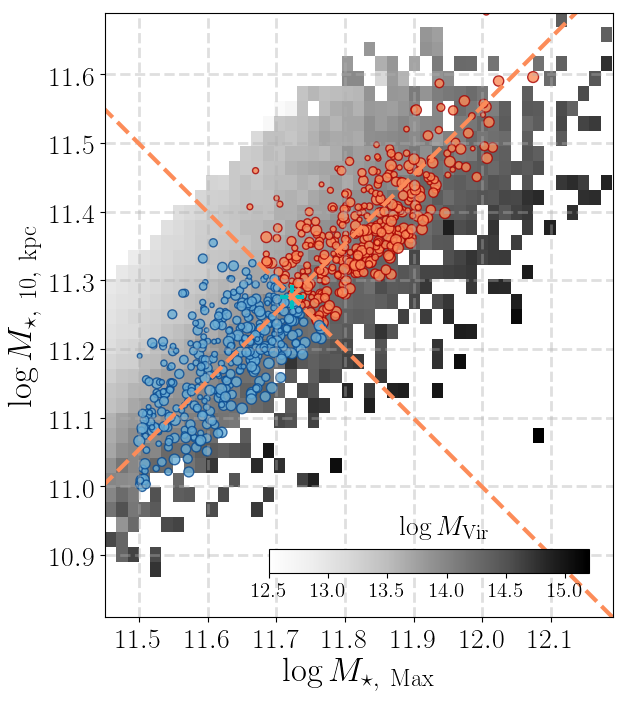

In [718]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

## M100-M10 scatter plot
x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod] + 0.02
z_arr = um_more['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 45))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.20,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

ax1.scatter(mtot_use[upp_mask], 
            minn_use[upp_mask], 
            s=(halo_use['logmh_vir'][upp_mask] - 13.96) * 260, 
            alpha=0.8, facecolor=ORG(0.5), edgecolor=ORG(0.9))

ax1.scatter(mtot_use[low_mask], 
            minn_use[low_mask], 
            s=(halo_use['logmh_vir'][low_mask] - 13.96) * 260, 
            alpha=0.8, facecolor=BLU(0.5), edgecolor=BLU(0.9))

mtot_arr = np.linspace(11.4, 12.2, 100)
ax1.plot(mtot_arr, 1.00 * mtot_arr - 0.44627, linestyle='--', linewidth=3.0, c=ORG(0.5))

ax1.scatter(np.nanmean(logms_mod_tot[mh_mask]), np.nanmean(logms_mod_inn[mh_mask]), 
            s=300, marker='+', c='c', linewidth=3.0)

ax1.plot(mtot_arr, -1.00 * mtot_arr + 22.9989, linestyle='--', linewidth=3.0, c=ORG(0.5))

# ax1.legend(fontsize=15, loc='upper left')

## Colorbar
cax = fig.add_axes([0.40, 0.18, 0.40, 0.03])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.58, 0.13, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=20)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)
ax1.set_aspect('equal')

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=25)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=25)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

In [721]:
um_rp_phy = np.logspace(np.log10(0.01), np.log10(40.0), 22)

upp_dsig = asap_um_dsigma(cfg_use, halo_use[upp_mask], dsig_use[upp_mask, :], 
                          mask=None, weight=None, r_interp=um_rp_phy)

low_dsig = asap_um_dsigma(cfg_use, halo_use[low_mask], dsig_use[low_mask, :], 
                          mask=None, weight=None, r_interp=um_rp_phy)

Text(0.5,0,'$r_{\\rm p}$ ${\\rm [Mpc]}$')

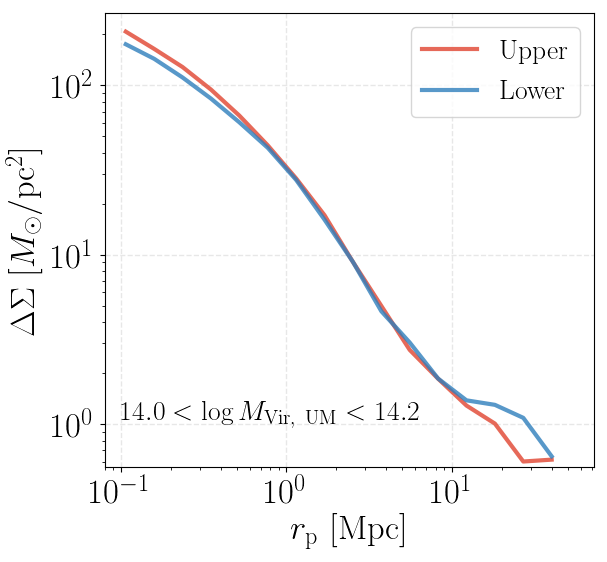

In [737]:
fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax.plot(um_rp_phy, upp_dsig,
        linewidth=3.0, color=ORG(0.7), alpha=0.8,
        label=r'$\mathrm{Upper}$')

ax.plot(um_rp_phy, low_dsig,
        linewidth=3.0, color=BLU(0.7), alpha=0.8,
        label=r'$\mathrm{Lower}$')

ax.legend(fontsize=20, loc='upper right')

ax.text(0.10, 1.0, r'$14.0 < \log M_{\rm Vir,\ UM} < 14.2$', fontsize=20)

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8
y_min = np.nanmin(um_dsig_halo_2) * 0.9
y_max = np.nanmax(um_dsig_halo_2) * 1.5

ax.set_xlim(0.08, x_max)
ax.set_ylim(y_min, y_max)

ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)